** 3.4 CartPoleをQ学習で制御 **

# パッケージのimport

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import gym

# 動画の描画関数の宣言

framesを食わせてanimationをmp4に保存し、再生
参考URL 
http://nbviewer.jupyter.org/github/patrickmineault/xcorr-notebooks/blob/master/Render%20OpenAI%20gym%20as%20GIF.ipynb


In [2]:
from JSAnimation.IPython_display import display_animation
from matplotlib import animation
from IPython.display import display


def display_frames_as_gif(frames):
    """
    Displays a list of frames as a gif, with controls
    """
    plt.figure(figsize=(frames[0].shape[1]/72.0, frames[0].shape[0]/72.0),
               dpi=72)
    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames=len(frames),
                                   interval=50)

    anim.save('movie_cartpole.mp4')  # 動画のファイル名と保存です
    display(display_animation(anim, default_mode='loop'))
    

In [3]:
plt.gcf?

# 定数の設定

In [4]:
ENV = 'CartPole-v0'  # 使用する課題名
NUM_DIZITIZED = 6  # 各状態の離散値への分割数
GAMMA = 0.99  # 時間割引率
ETA = 0.5  # 学習係数
MAX_STEPS = 200  # 1試行のstep数
NUM_EPISODES = 1000  # 最大試行回数

# CartPoleのエージェントクラス

棒付き台車そのものになります'''

In [5]:
class Agent:
    '''CartPoleのエージェントクラスです、棒付き台車そのものになります'''

    def __init__(self, num_states, num_actions):
        self.brain = Brain(num_states, num_actions)  # エージェントが行動を決定するための頭脳を生成

    def update_Q_function(self, observation, action, reward, observation_next):
        '''Q関数の更新'''
        self.brain.update_Q_table(
            observation, action, reward, observation_next)

    def get_action(self, observation, step):
        '''行動の決定'''
        action = self.brain.decide_action(observation, step)
        return action
    

# brain : エージェントが持つ脳となるクラス

Q学習を実行します

In [6]:
class Brain:
    '''エージェントが持つ脳となるクラスです、Q学習を実行します'''

    def __init__(self, num_states, num_actions):
        self.num_actions = num_actions  # CartPoleの行動（右に左に押す）の2を取得

        # Qテーブルを作成。行数は状態を分割数^（4変数）にデジタル変換した値、列数は行動数を示す
        self.q_table = np.random.uniform(low=0, high=1, size=(
            NUM_DIZITIZED**num_states, num_actions))


    def bins(self, clip_min, clip_max, num):
        '''観測した状態（連続値）を離散値にデジタル変換する閾値を求める'''
        return np.linspace(clip_min, clip_max, num + 1)[1:-1]

    def digitize_state(self, observation):
        '''観測したobservation状態を、離散値に変換する'''
        cart_pos, cart_v, pole_angle, pole_v = observation
        digitized = [
            np.digitize(cart_pos, bins=self.bins(-2.4, 2.4, NUM_DIZITIZED)),
            np.digitize(cart_v, bins=self.bins(-3.0, 3.0, NUM_DIZITIZED)),
            np.digitize(pole_angle, bins=self.bins(-0.5, 0.5, NUM_DIZITIZED)),
            np.digitize(pole_v, bins=self.bins(-2.0, 2.0, NUM_DIZITIZED))
        ]
        return sum([x * (NUM_DIZITIZED**i) for i, x in enumerate(digitized)])

    def update_Q_table(self, observation, action, reward, observation_next):
        '''QテーブルをQ学習により更新'''
        state = self.digitize_state(observation)  # 状態を離散化
        state_next = self.digitize_state(observation_next)  # 次の状態を離散化
        Max_Q_next = max(self.q_table[state_next][:])
        self.q_table[state, action] = self.q_table[state, action] + \
            ETA * (reward + GAMMA * Max_Q_next - self.q_table[state, action])

    def decide_action(self, observation, episode):
        '''ε-greedy法で徐々に最適行動のみを採用する'''
        state = self.digitize_state(observation)
        epsilon = 0.5 * (1 / (episode + 1))

        if epsilon <= np.random.uniform(0, 1):
            action = np.argmax(self.q_table[state][:])
        else:
            action = np.random.choice(self.num_actions)  # 0,1の行動をランダムに返す
        return action
    

# Environment

- EnvironmentはAgentを操作する
- Agentは自分のBrainを使って、以下を行うことができる
 - action決定
 - Qの更新

In [8]:
class Environment:
    '''CartPoleを実行する環境のクラスです'''

    def __init__(self):
        self.env = gym.make(ENV)  # 実行する課題を設定
        num_states = self.env.observation_space.shape[0]  # 課題の状態の数4を取得
        num_actions = self.env.action_space.n  # CartPoleの行動（右に左に押す）の2を取得
        self.agent = Agent(num_states, num_actions)  # 環境内で行動するAgentを生成

    def run(self):
        '''実行'''
        complete_episodes = 0  # 195step以上連続で立ち続けた試行数
        is_episode_final = False  # 最終試行フラグ
        frames = []  # 動画用に画像を格納する変数

        for episode in range(NUM_EPISODES):  # 試行数分繰り返す
            observation = self.env.reset()  # 環境の初期化

            for step in range(MAX_STEPS):  # 1エピソードのループ

                if is_episode_final is True:  # 最終試行ではframesに各時刻の画像を追加していく
                    frames.append(self.env.render(mode='rgb_array'))

                # 行動を求める
                action = self.agent.get_action(observation, episode)

                # 行動a_tの実行により、s_{t+1}, r_{t+1}を求める
                observation_next, _, done, _ = self.env.step(
                    action)  # rewardとinfoは使わないので_にする

                # 報酬を与える
                if done:  # ステップ数が200経過するか、一定角度以上傾くとdoneはtrueになる
                    if step < 195:
                        reward = -1  # 途中でこけたら罰則として報酬-1を与える
                        complete_episodes = 0  # 195step以上連続で立ち続けた試行数をリセット
                    else:
                        reward = 1  # 立ったまま終了時は報酬1を与える
                        complete_episodes += 1  # 連続記録を更新
                else:
                    reward = 0  # 途中の報酬は0

                # step+1の状態observation_nextを用いて,Q関数を更新する
                self.agent.update_Q_function(
                    observation, action, reward, observation_next)

                # 観測の更新
                observation = observation_next

                # 終了時の処理
                if done:
                    print('{0} Episode: Finished after {1} time steps'.format(
                        episode, step + 1))
                    break

            if is_episode_final is True:  # 最終試行では動画を保存と描画
                display_frames_as_gif(frames)
                break

            if complete_episodes >= 10:  # 10連続成功なら
                print('10回連続成功')
                is_episode_final = True  # 次の試行を描画を行う最終試行とする
                

0 Episode: Finished after 56 time steps
1 Episode: Finished after 22 time steps
2 Episode: Finished after 22 time steps
3 Episode: Finished after 12 time steps
4 Episode: Finished after 45 time steps
5 Episode: Finished after 43 time steps
6 Episode: Finished after 22 time steps
7 Episode: Finished after 66 time steps
8 Episode: Finished after 51 time steps
9 Episode: Finished after 21 time steps
10 Episode: Finished after 34 time steps
11 Episode: Finished after 68 time steps
12 Episode: Finished after 74 time steps
13 Episode: Finished after 28 time steps
14 Episode: Finished after 61 time steps
15 Episode: Finished after 30 time steps
16 Episode: Finished after 13 time steps
17 Episode: Finished after 48 time steps
18 Episode: Finished after 29 time steps
19 Episode: Finished after 23 time steps
20 Episode: Finished after 32 time steps
21 Episode: Finished after 46 time steps
22 Episode: Finished after 64 time steps
23 Episode: Finished after 11 time steps
24 Episode: Finished after

201 Episode: Finished after 200 time steps
202 Episode: Finished after 200 time steps
203 Episode: Finished after 200 time steps
204 Episode: Finished after 200 time steps
205 Episode: Finished after 200 time steps
206 Episode: Finished after 141 time steps
207 Episode: Finished after 200 time steps
208 Episode: Finished after 200 time steps
209 Episode: Finished after 200 time steps
210 Episode: Finished after 200 time steps
211 Episode: Finished after 200 time steps
212 Episode: Finished after 200 time steps
213 Episode: Finished after 200 time steps
214 Episode: Finished after 200 time steps
215 Episode: Finished after 200 time steps
216 Episode: Finished after 200 time steps
10回連続成功
217 Episode: Finished after 200 time steps



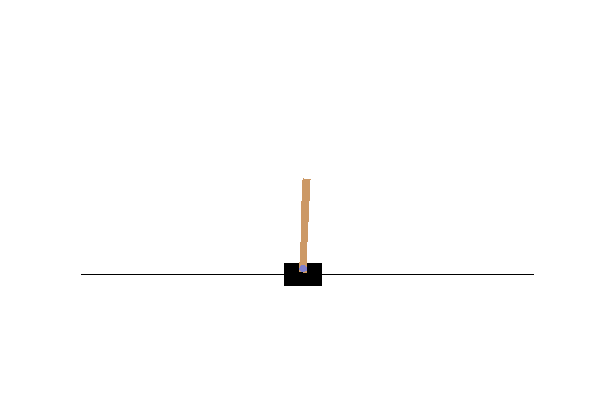
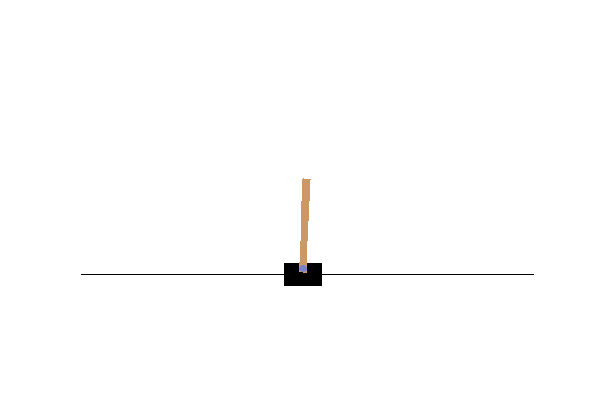
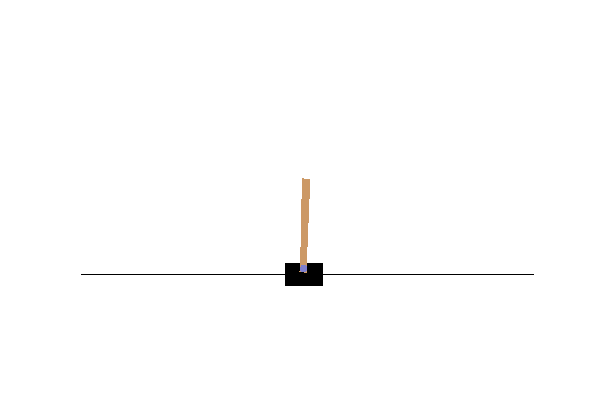
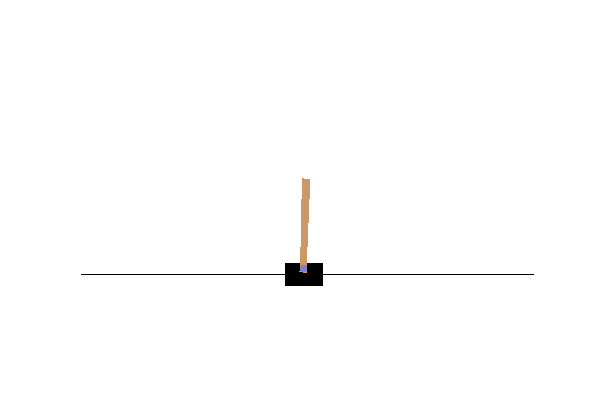
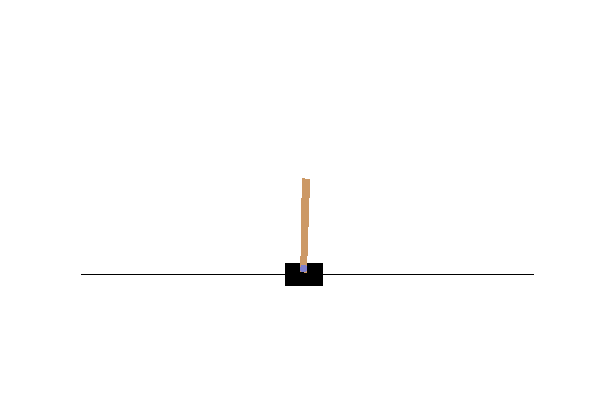
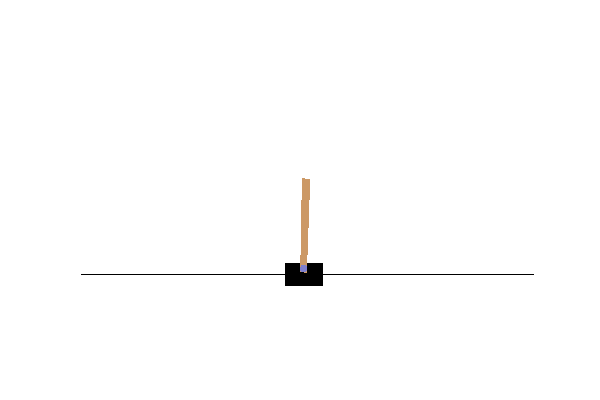
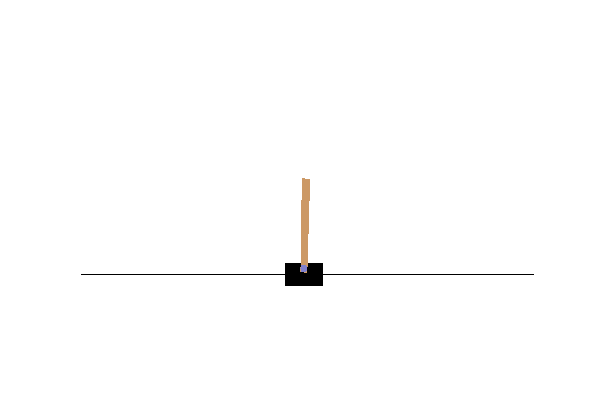
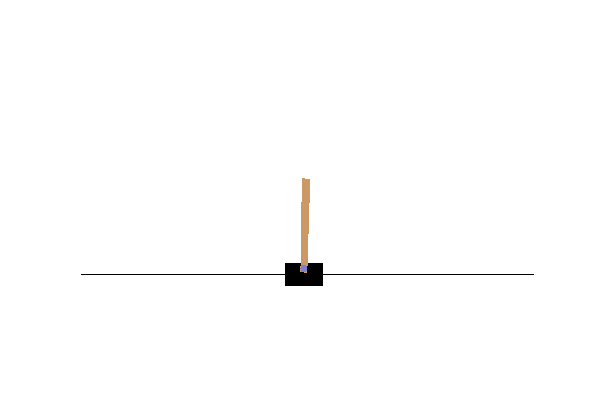
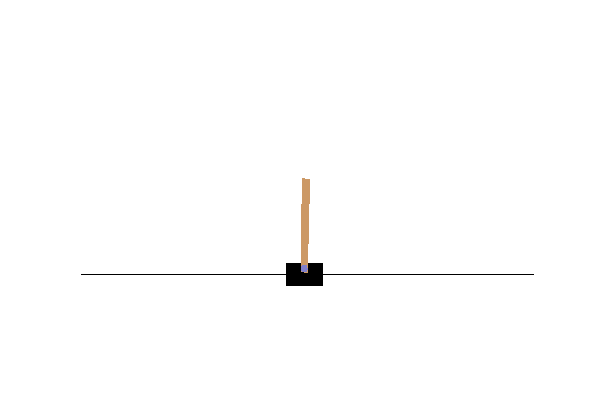
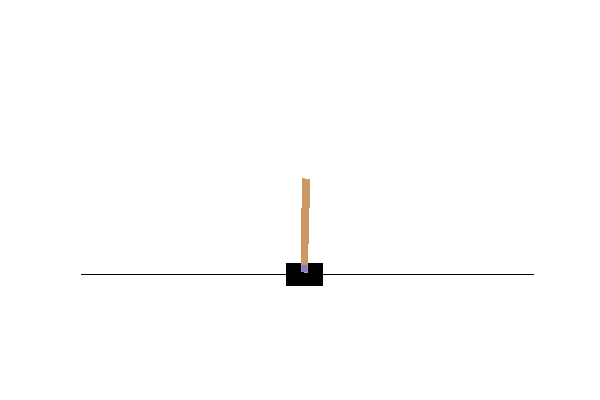
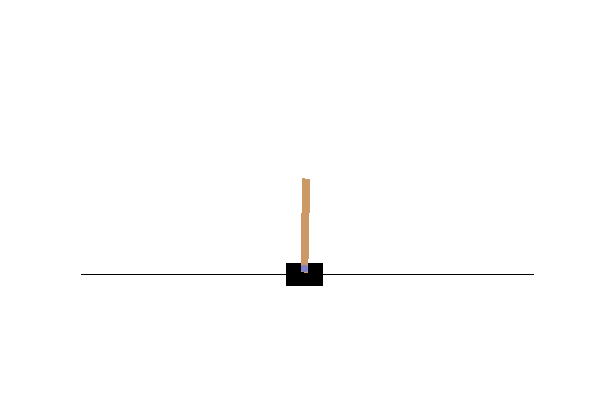
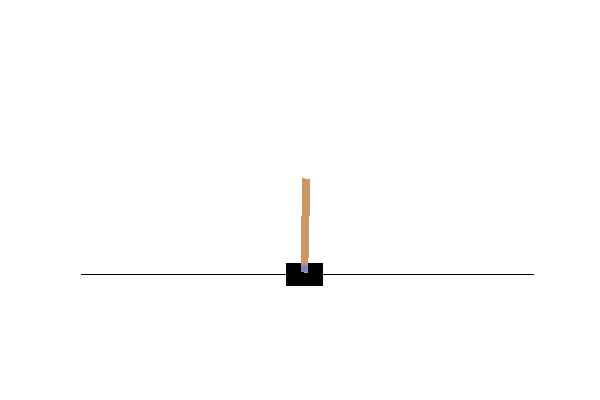
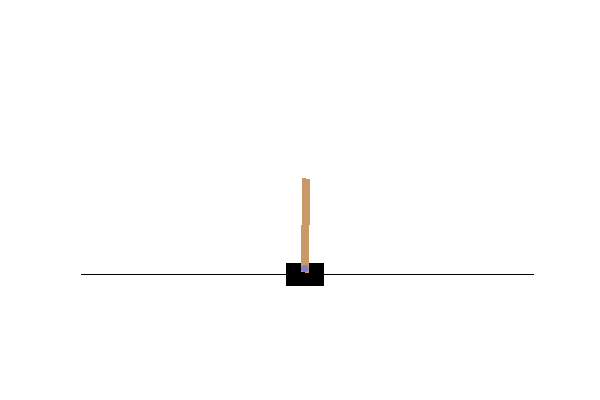
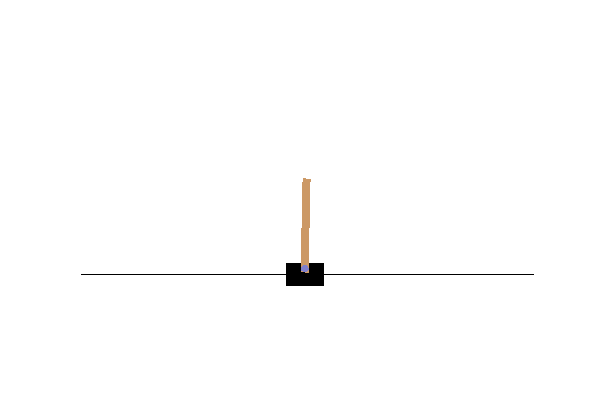
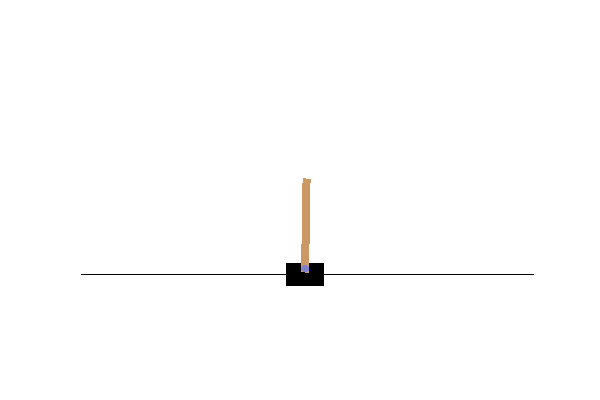
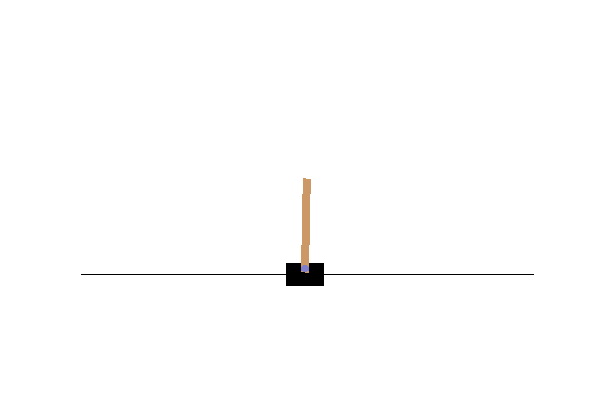
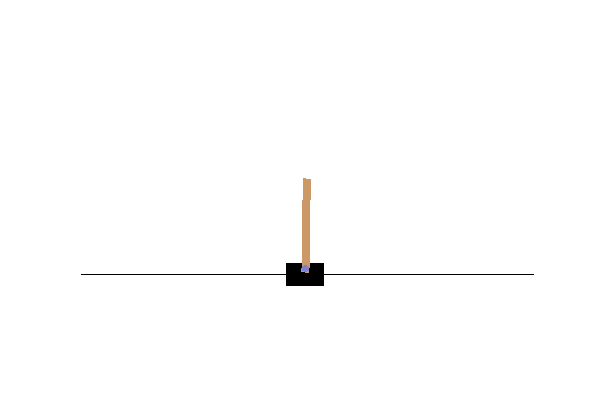
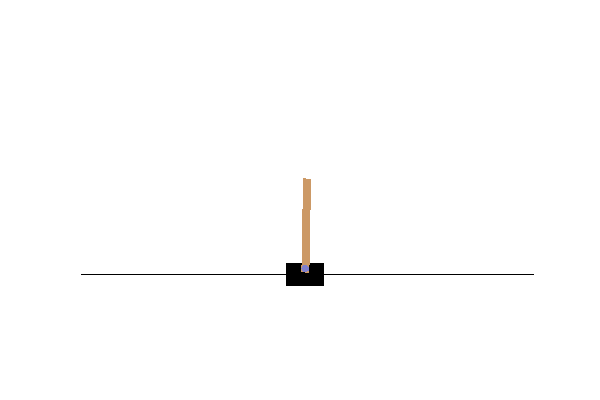
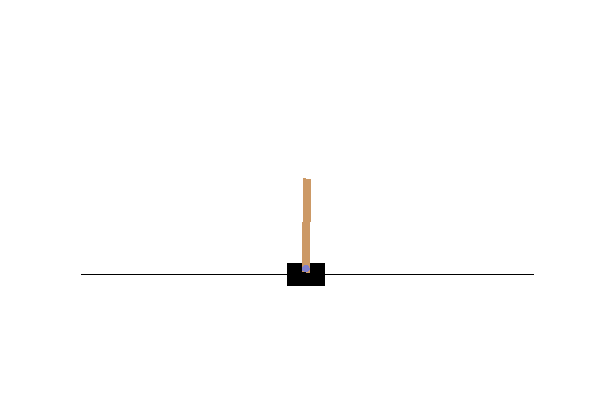
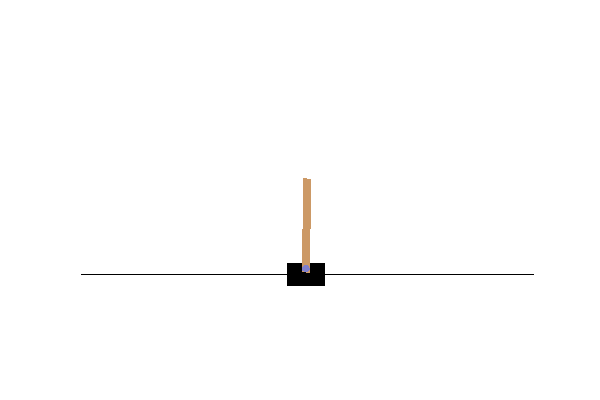
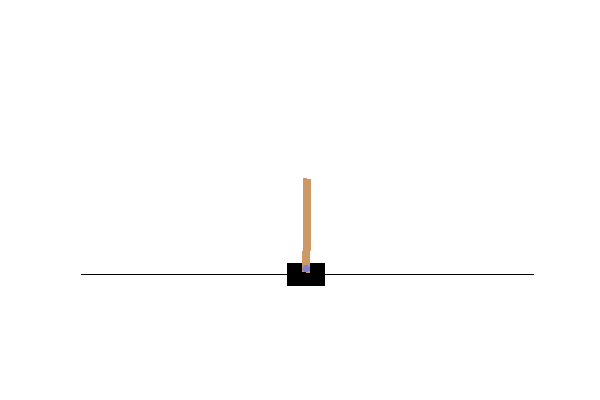
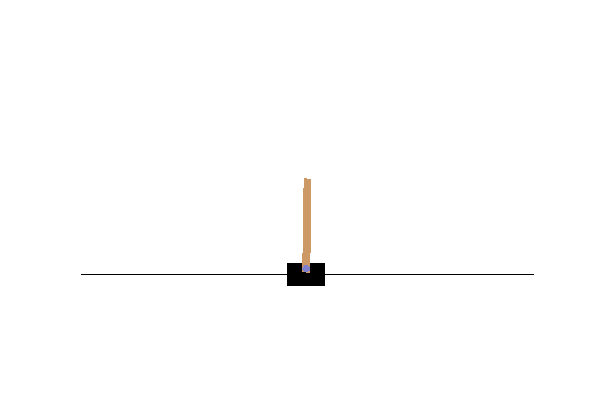
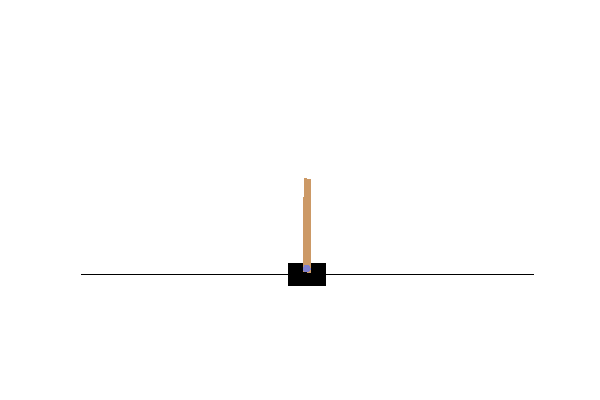
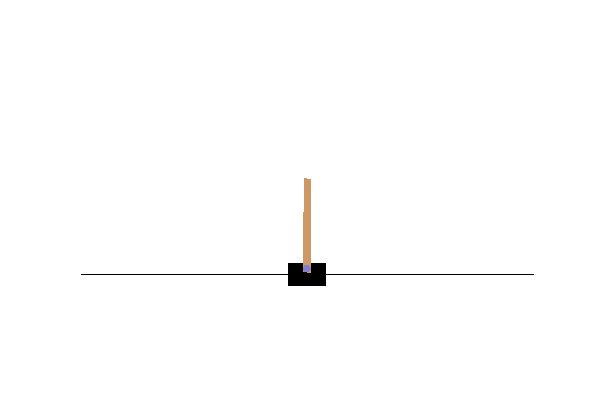
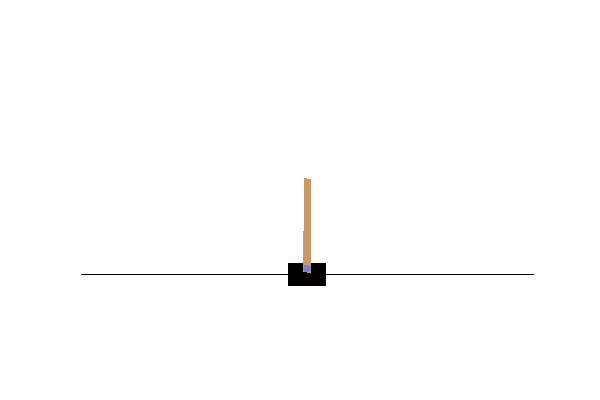
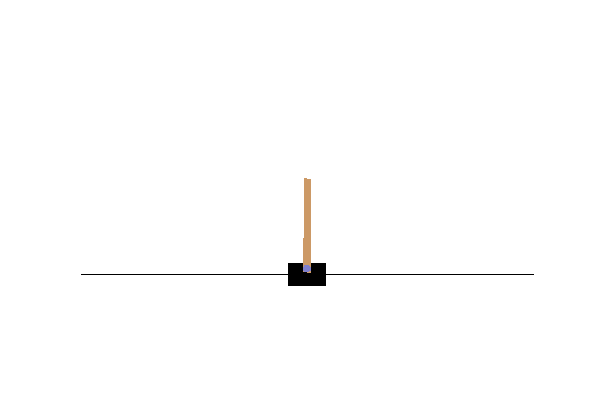
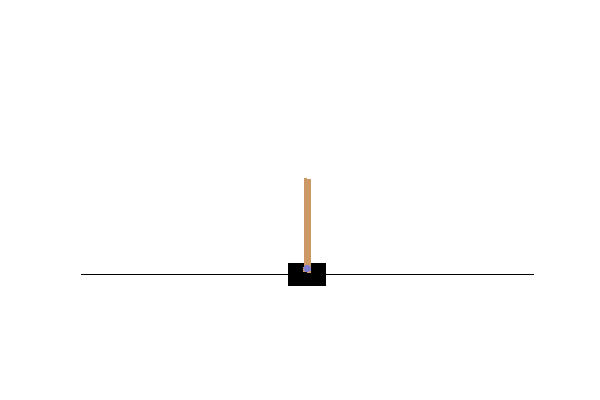
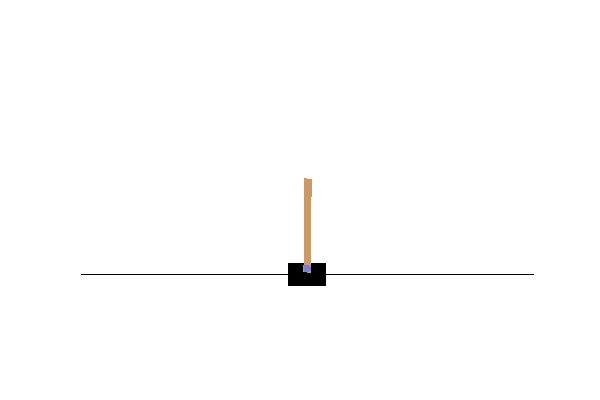
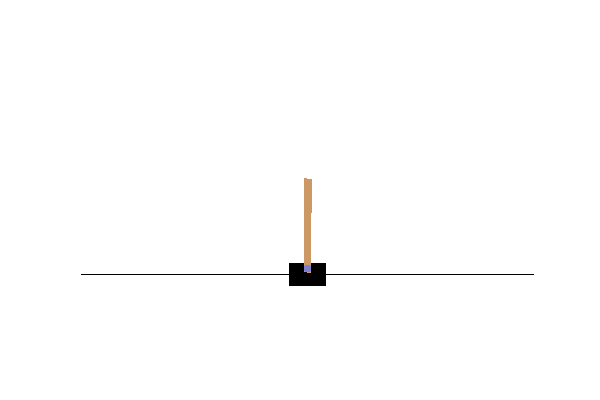
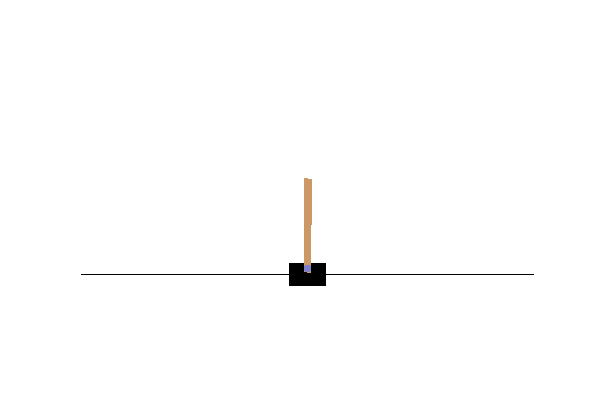
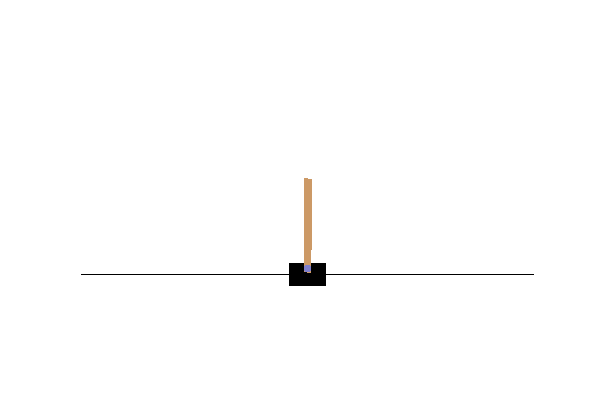
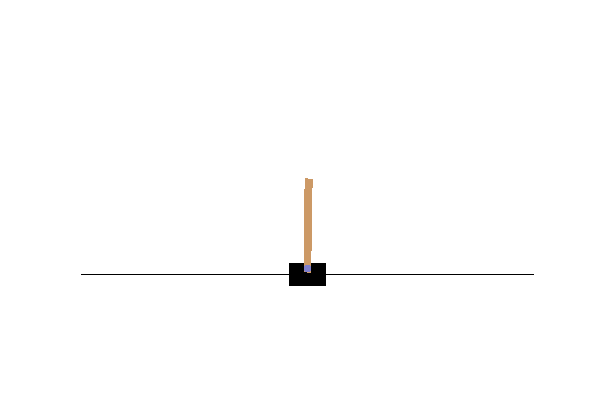
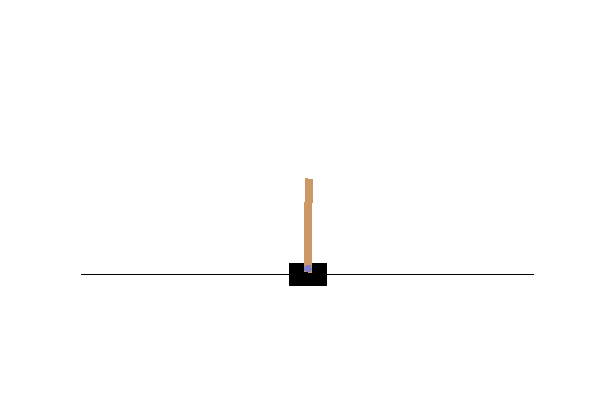
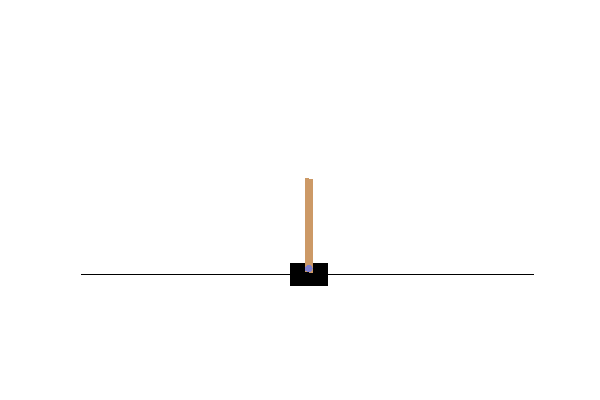
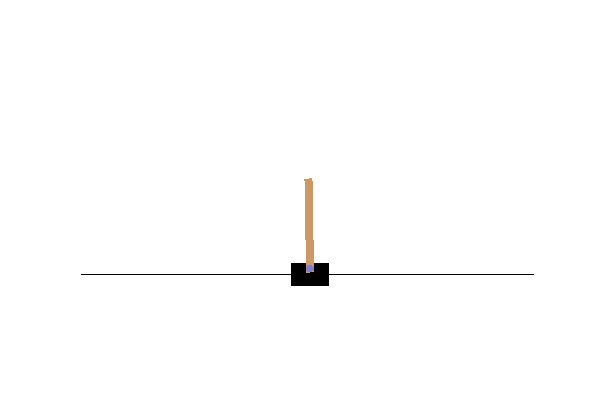
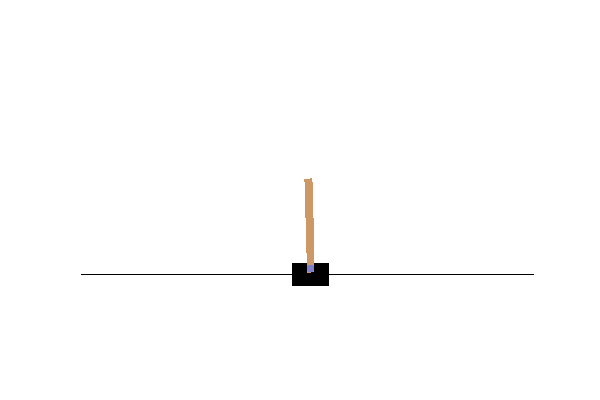
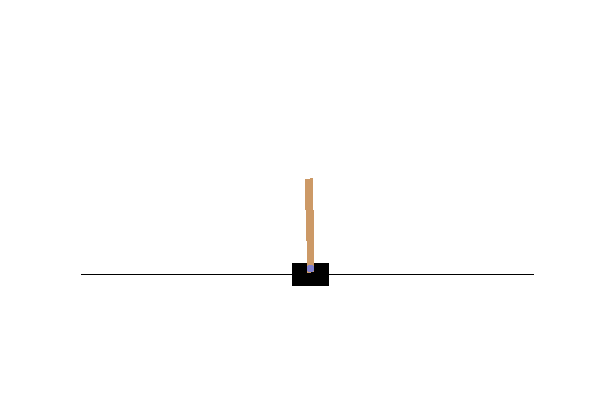
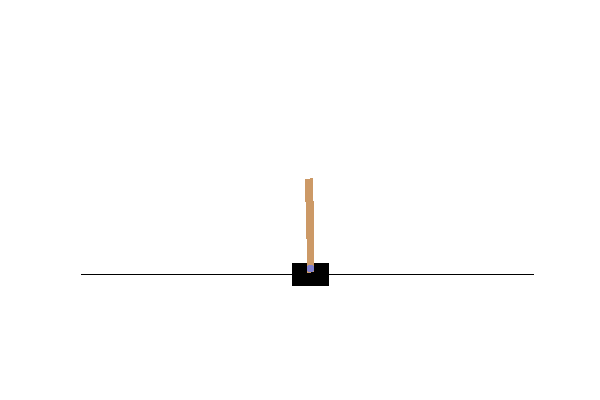
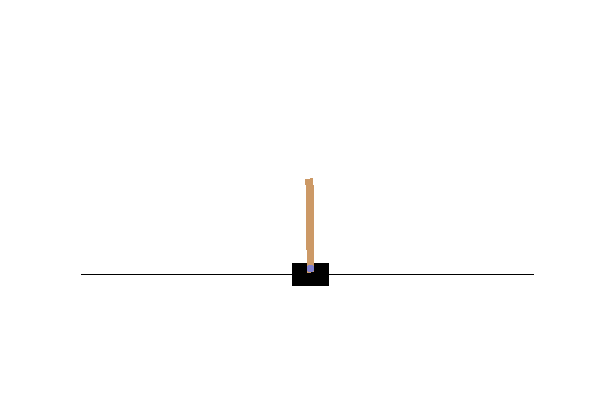
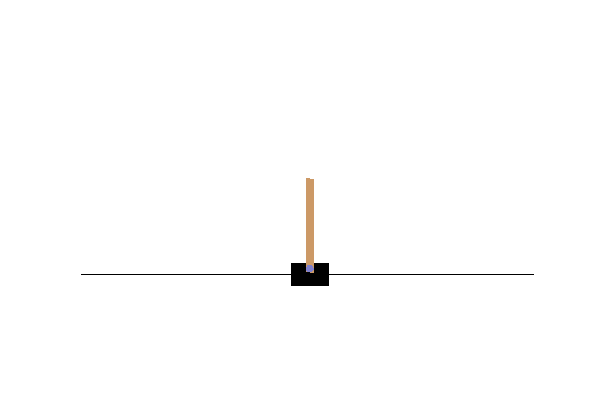
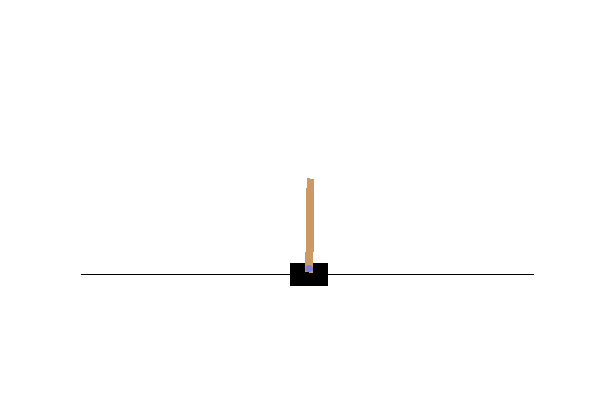
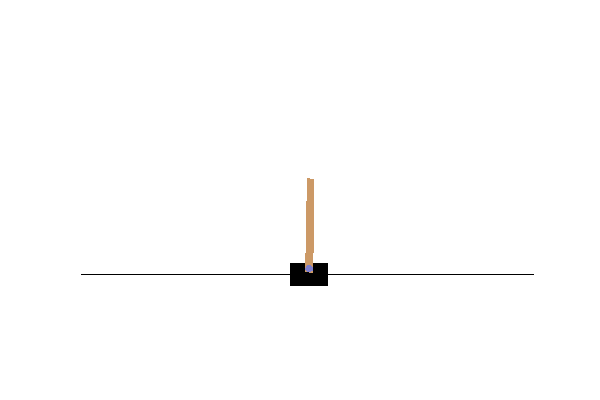
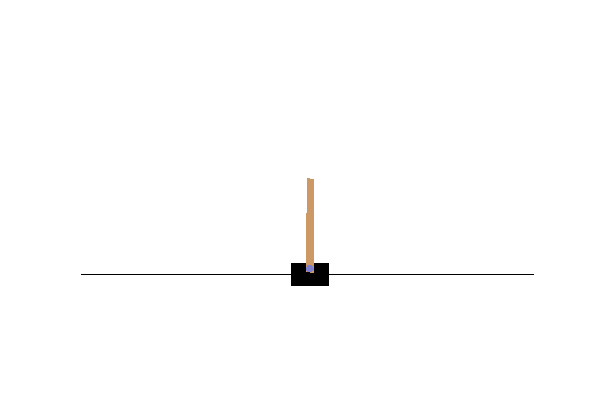
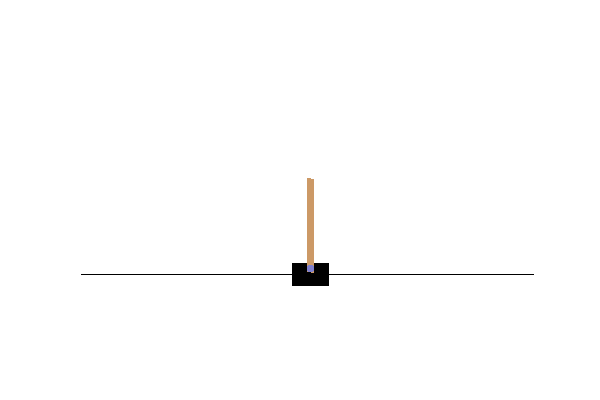
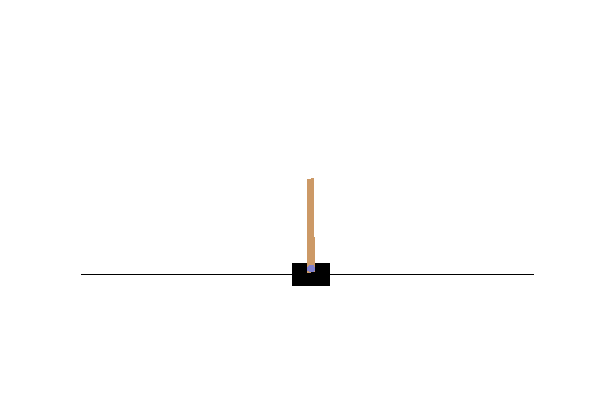
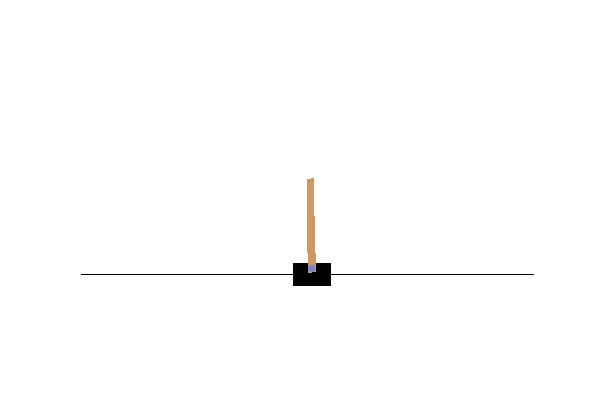
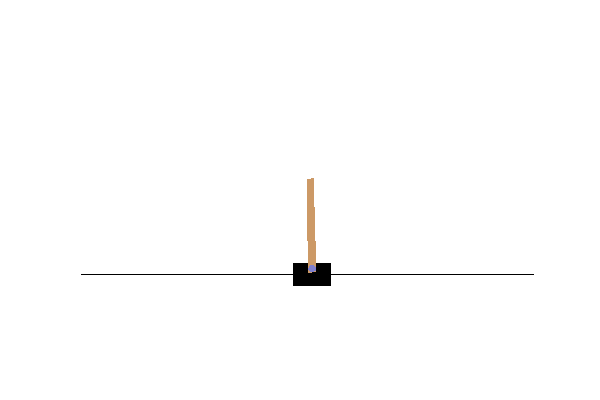
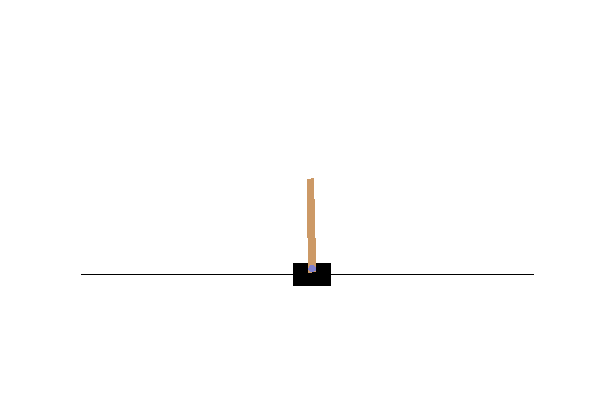
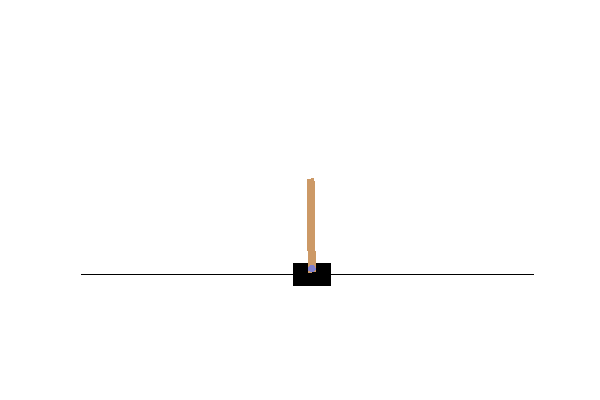
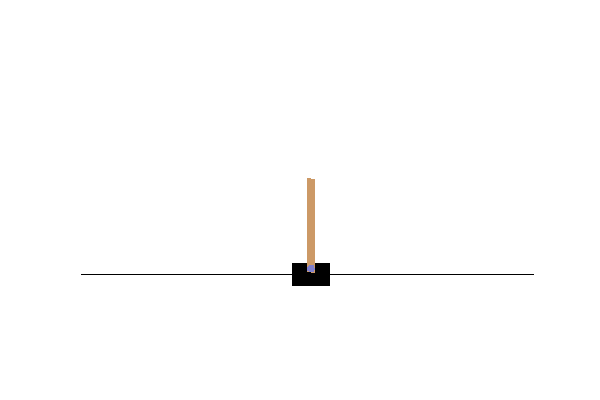
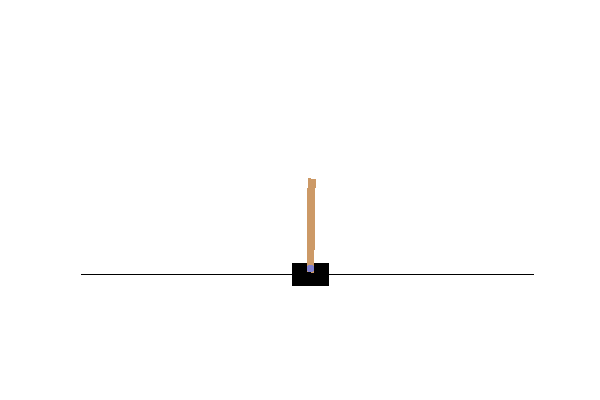
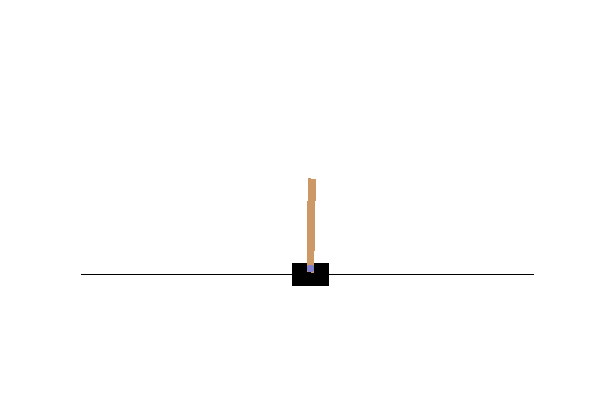
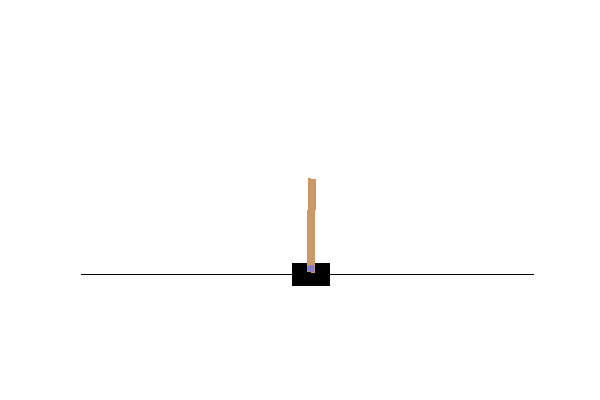
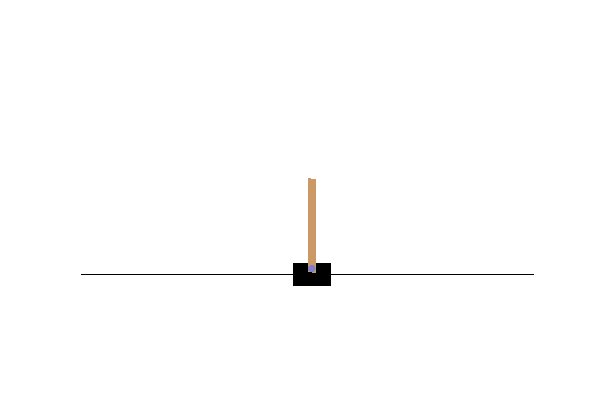
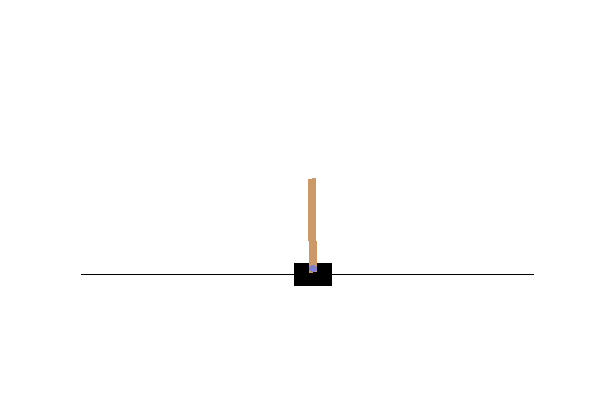
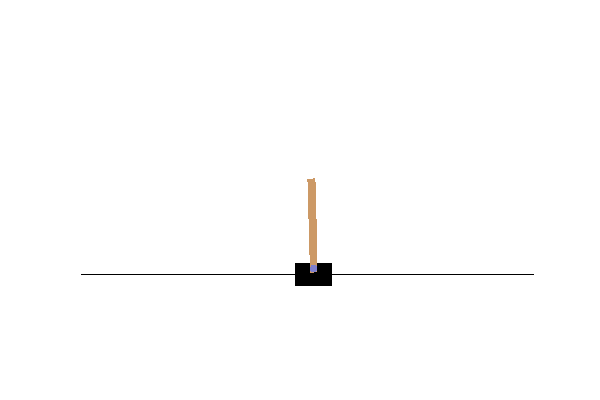
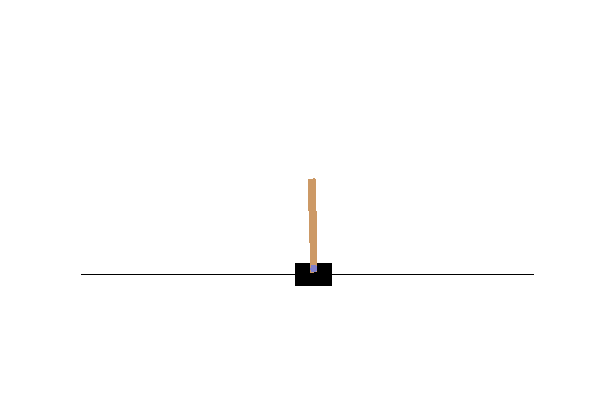
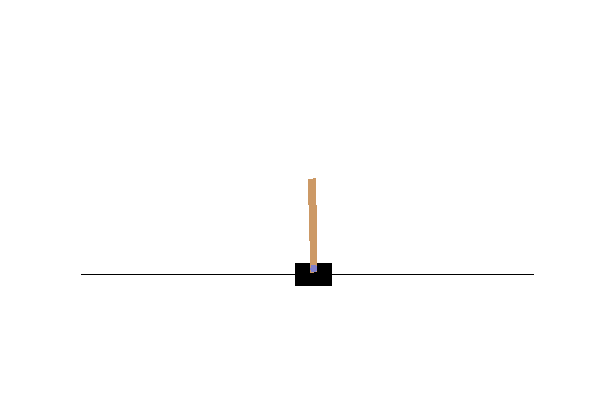
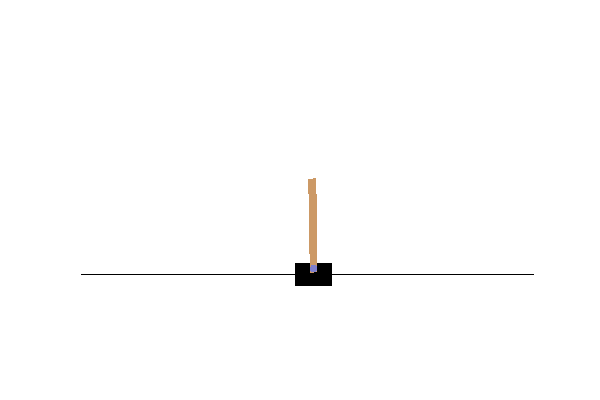
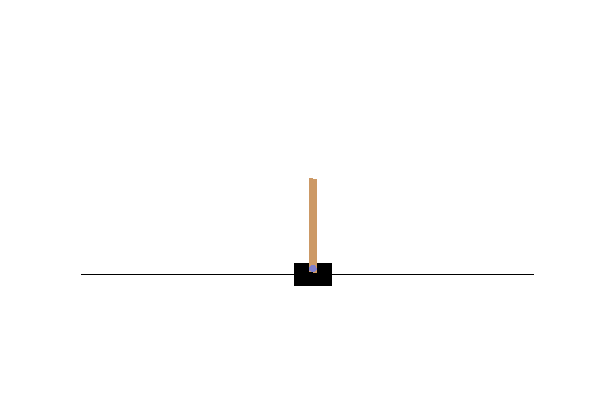
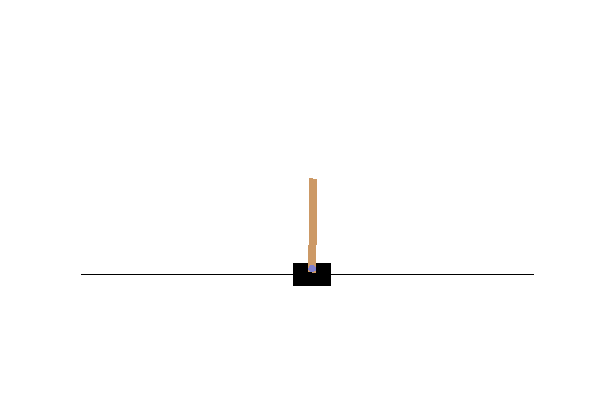
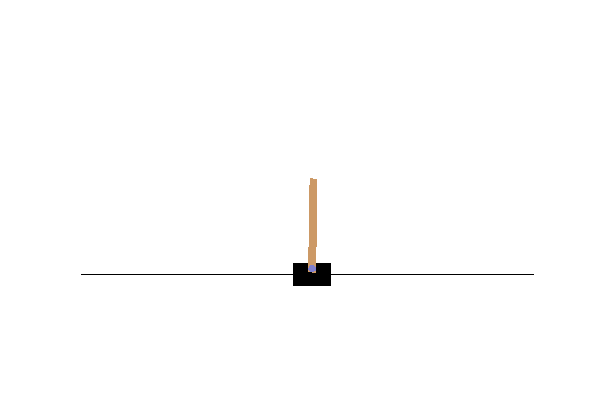
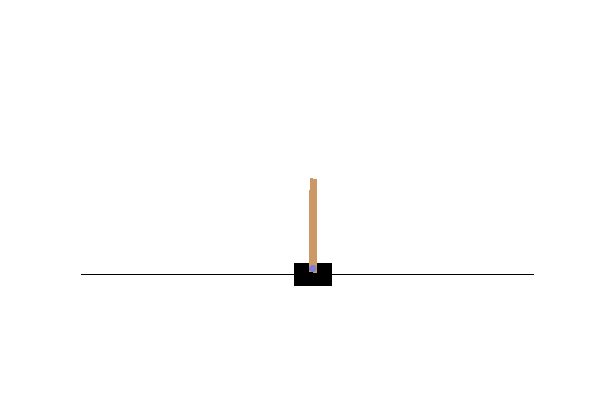
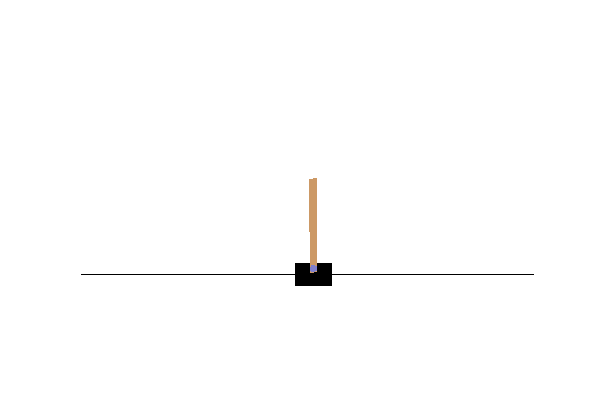
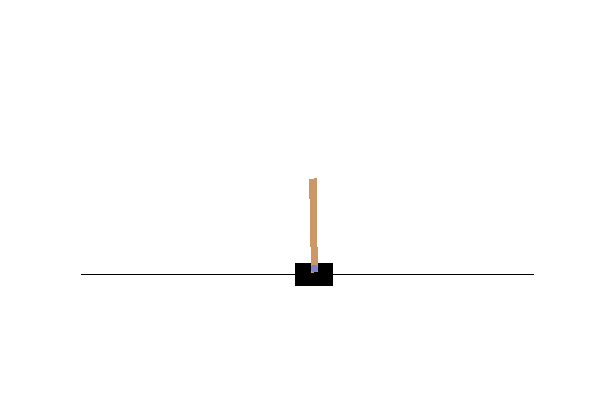
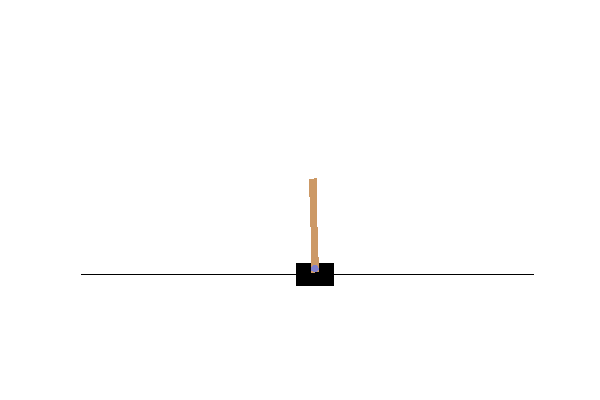
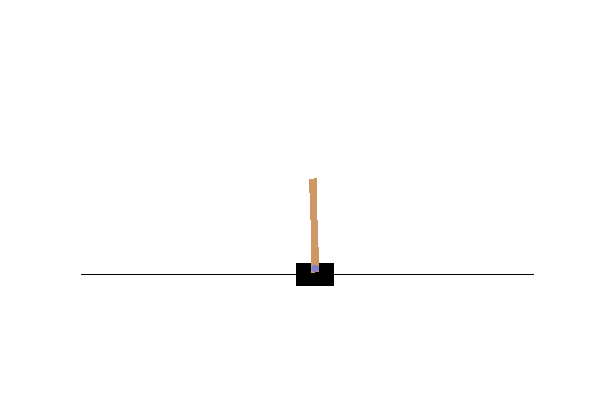
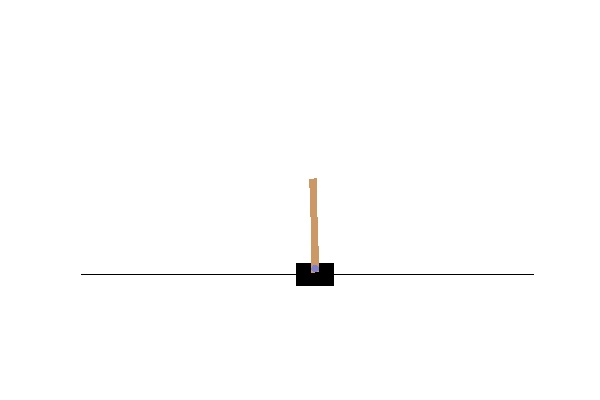
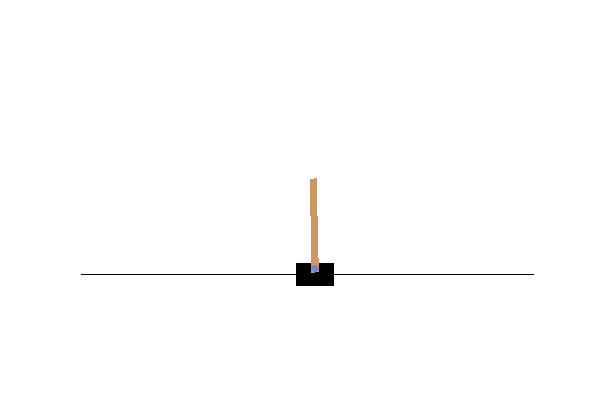
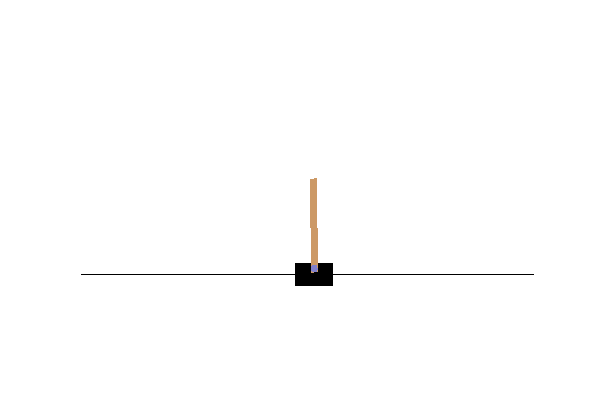
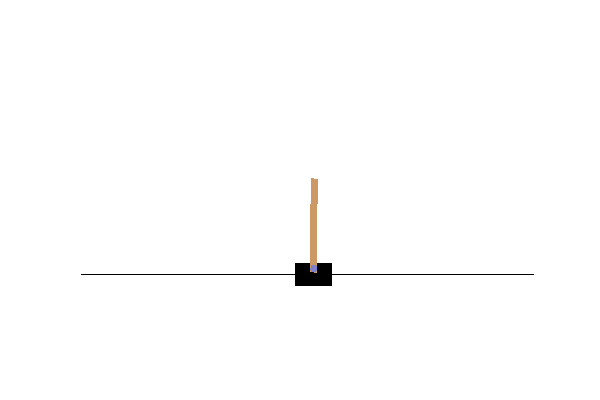
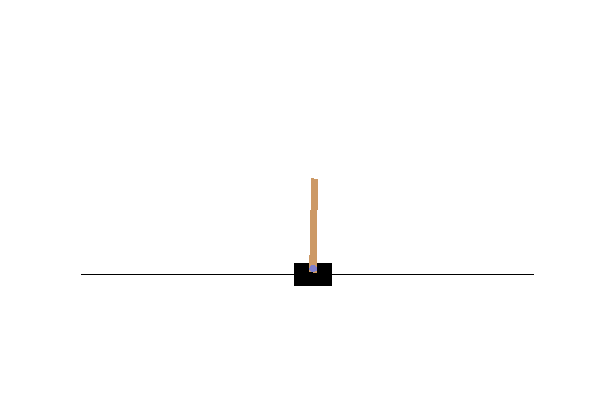
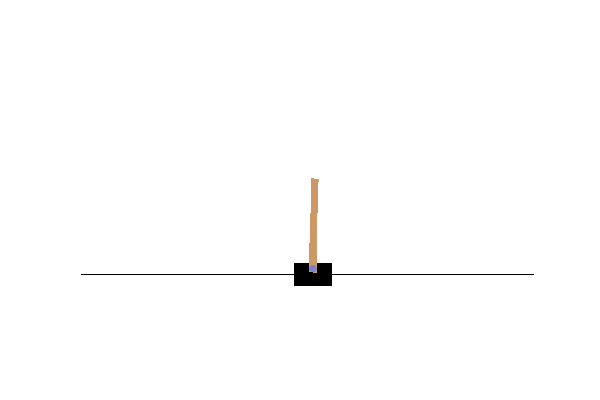
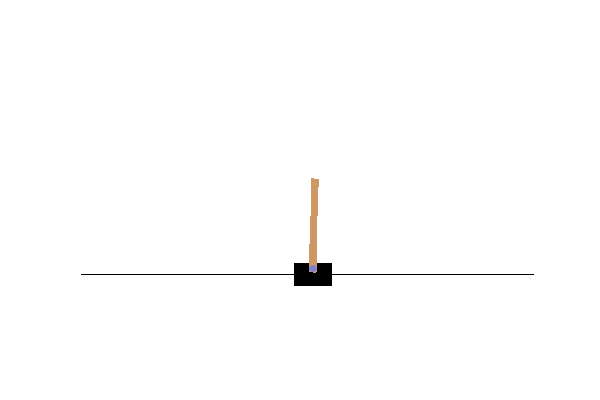
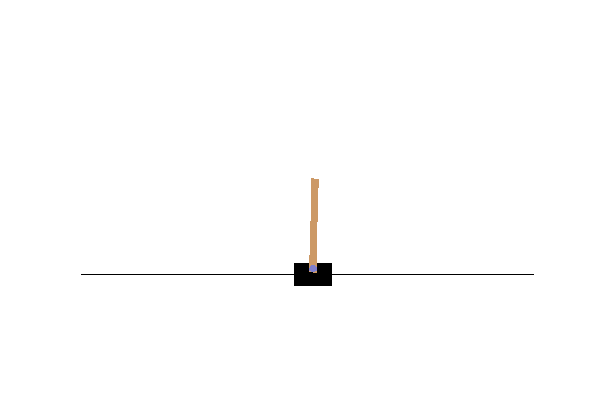
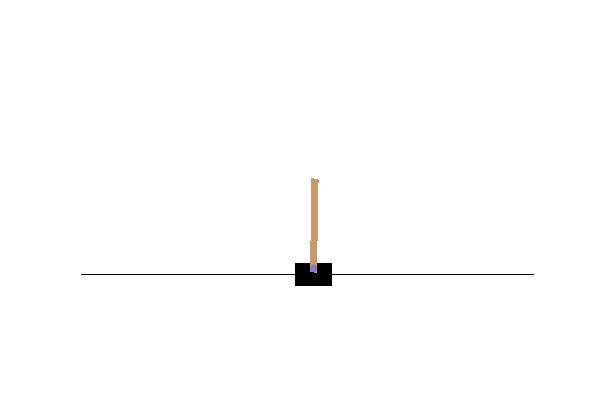
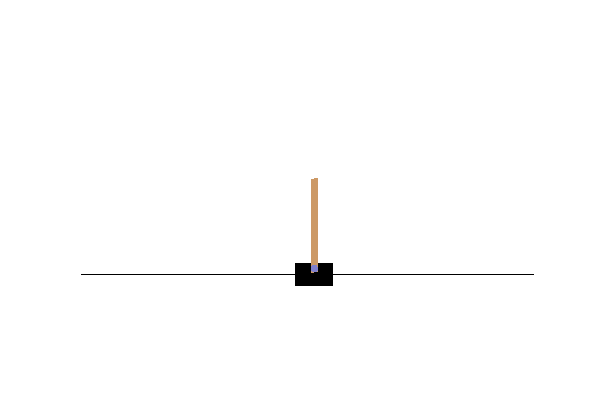
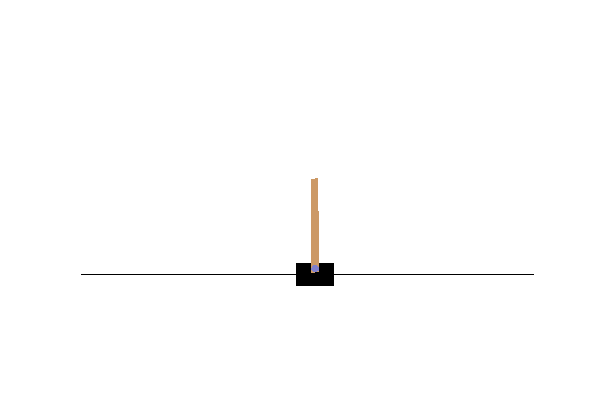
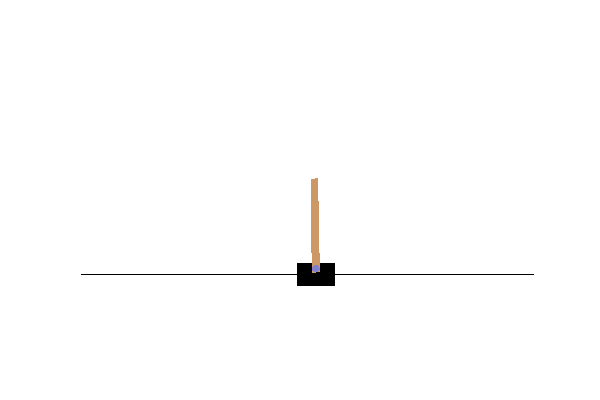
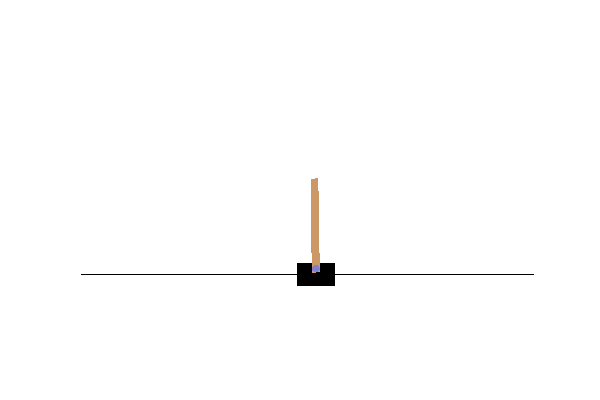
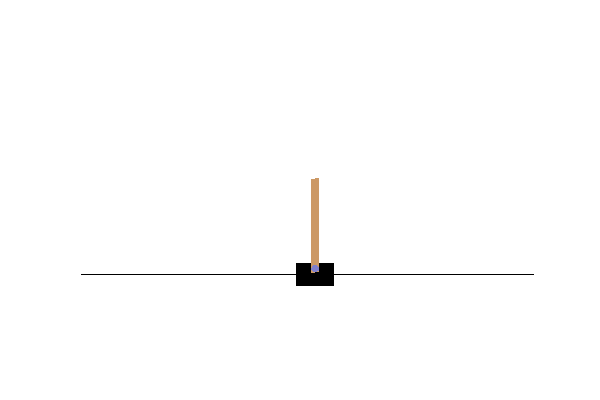
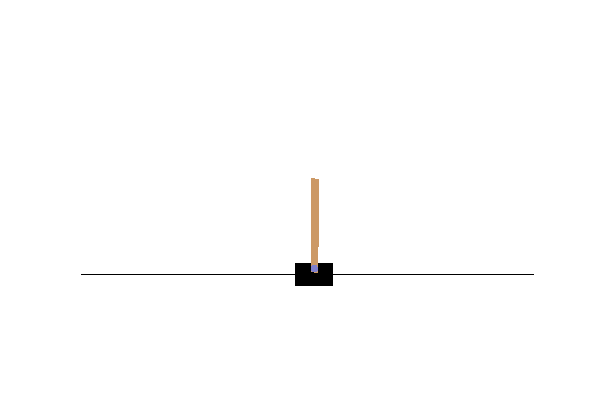
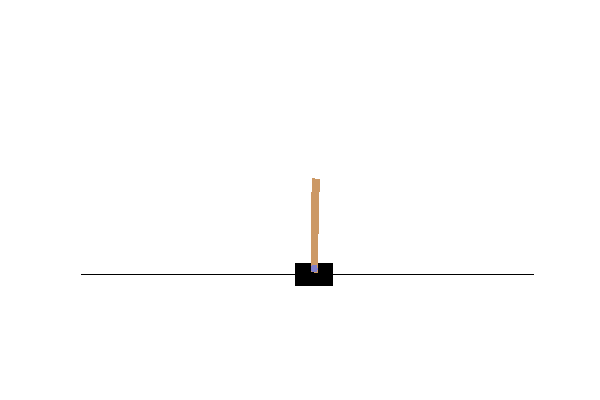
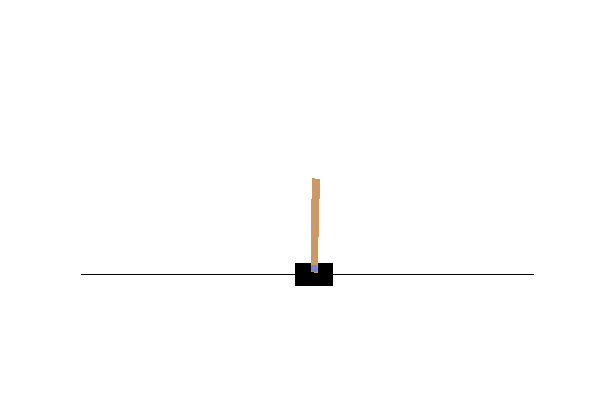
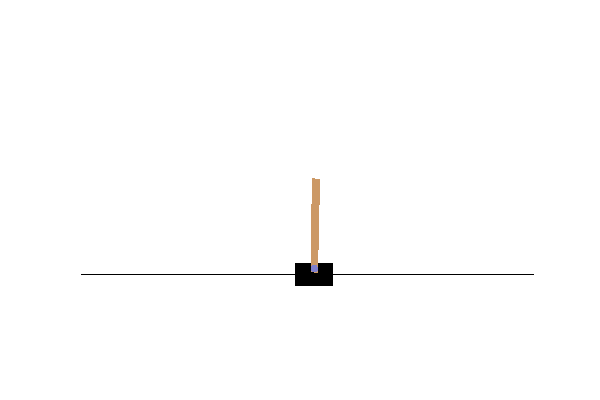
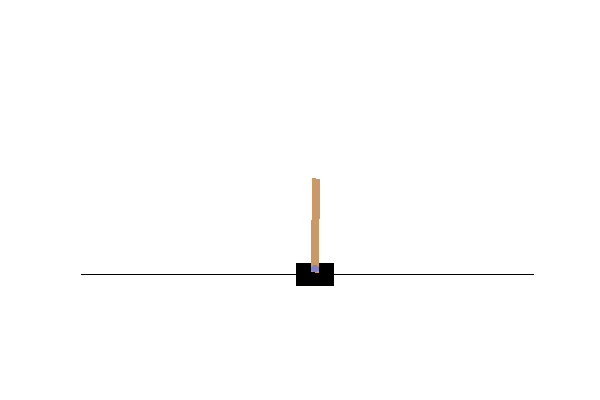
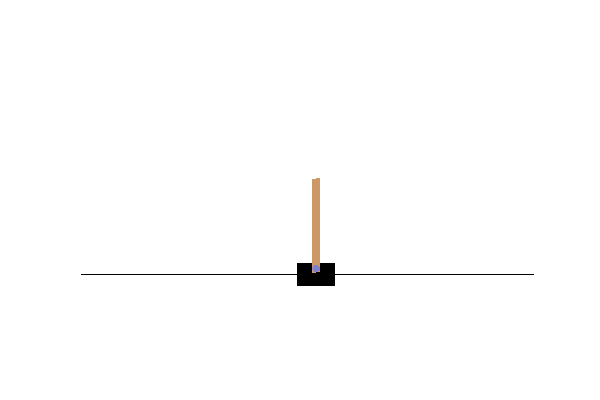
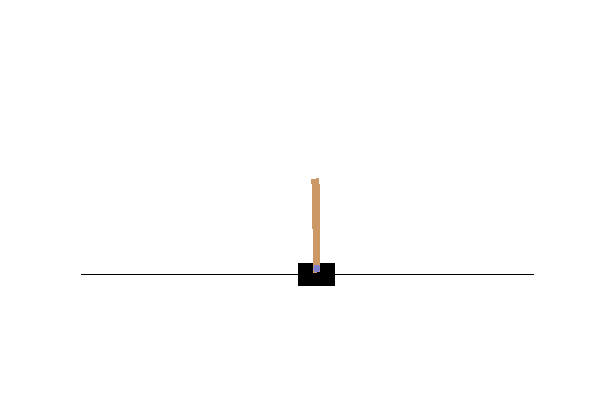
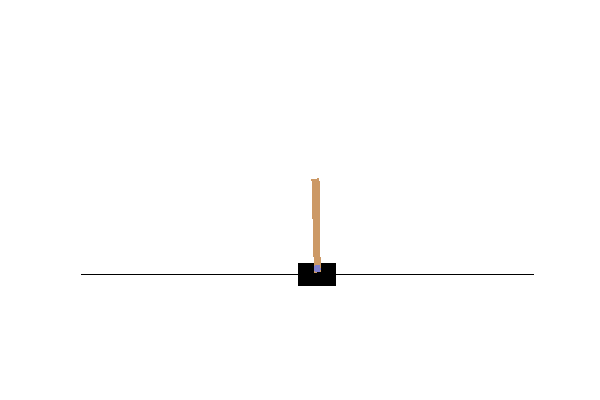
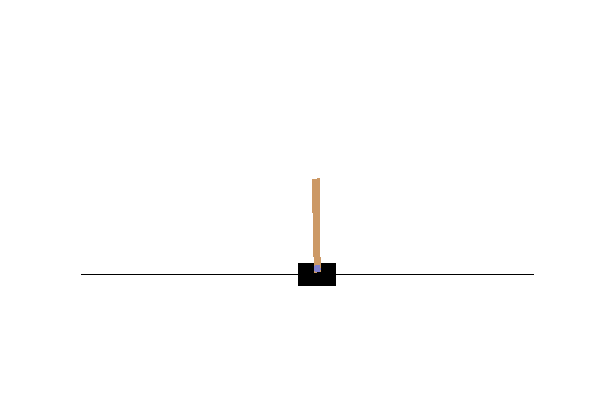
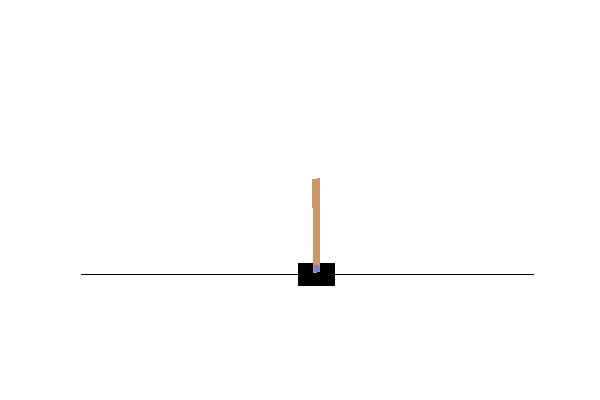
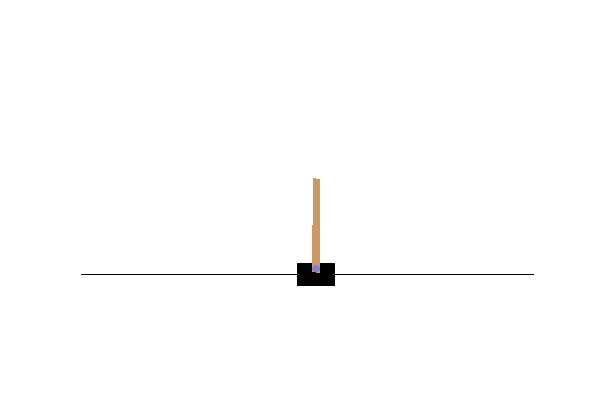
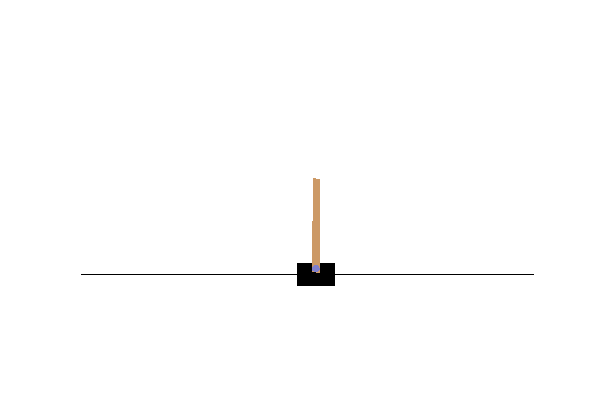
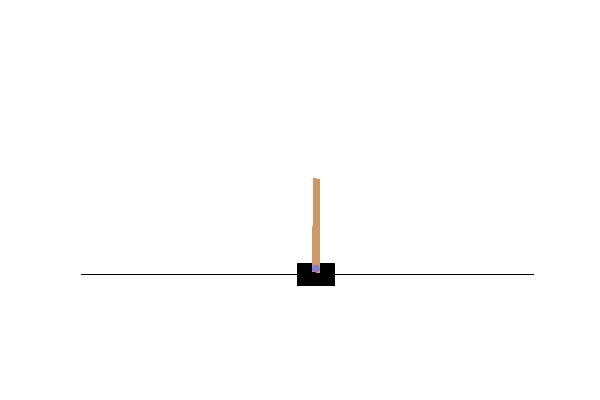
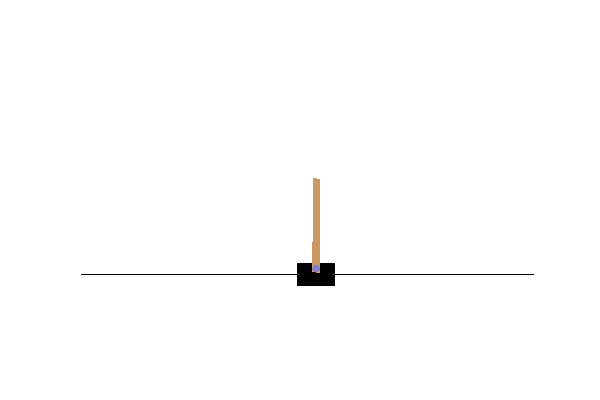
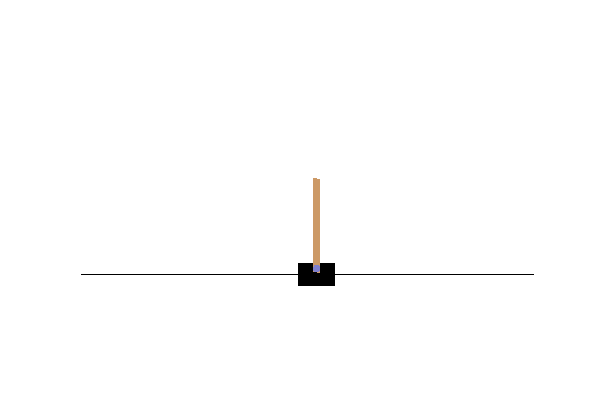
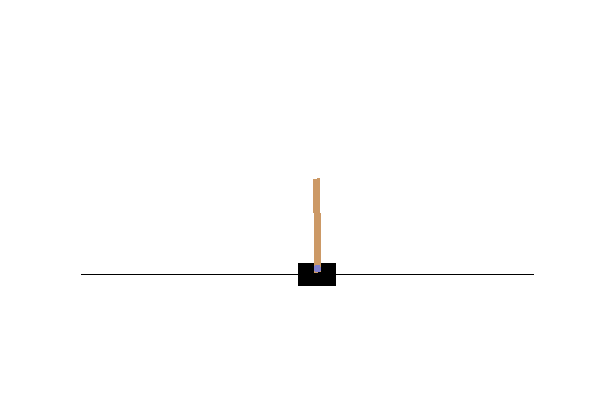
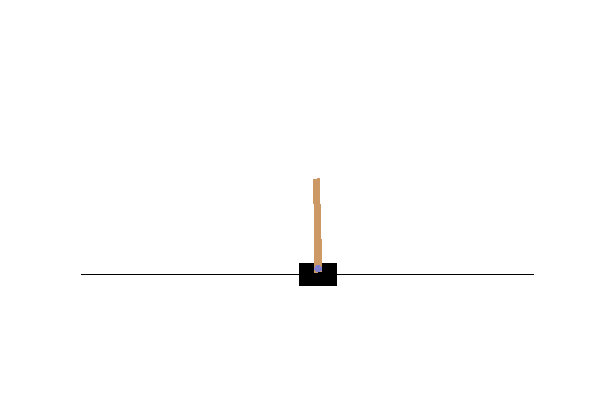
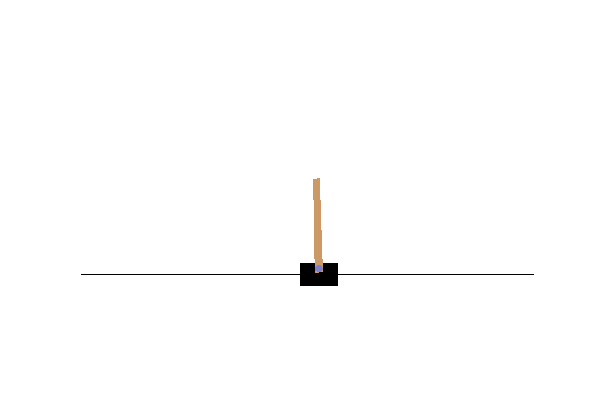
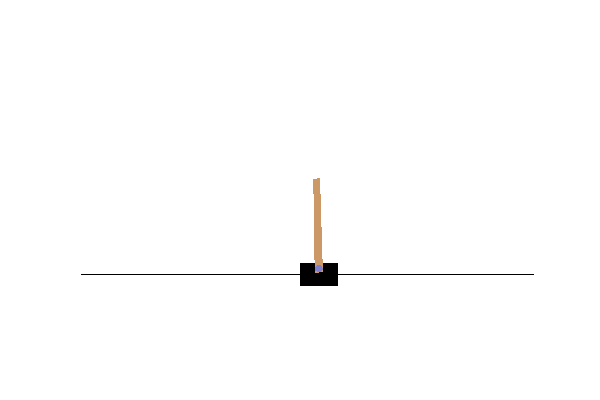
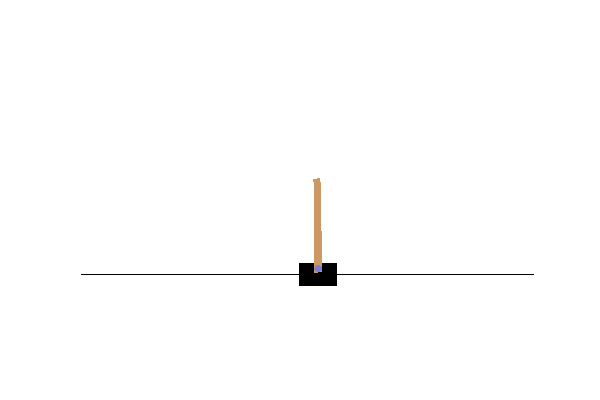
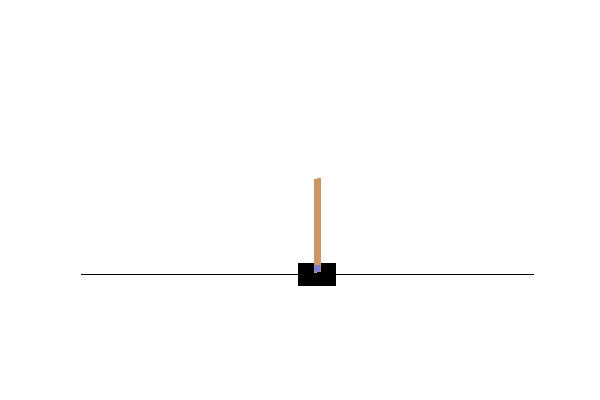
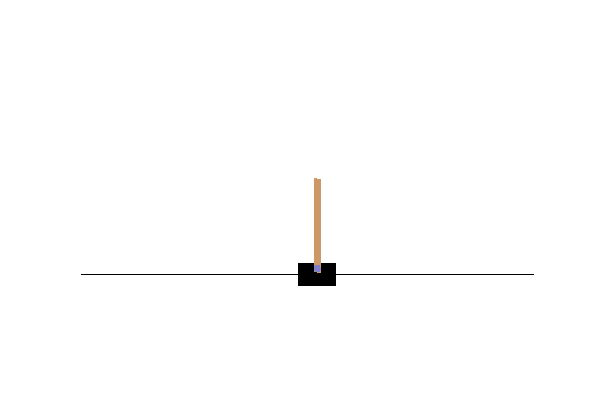
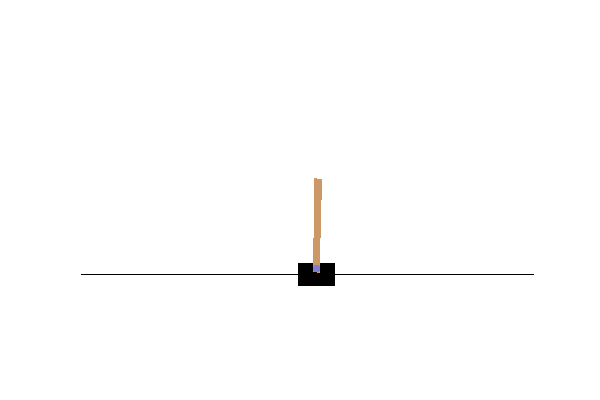
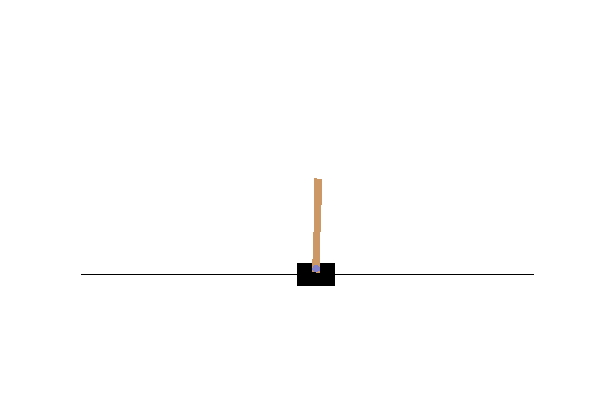
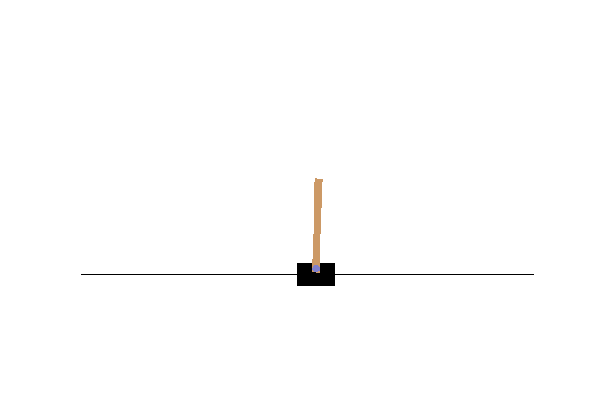
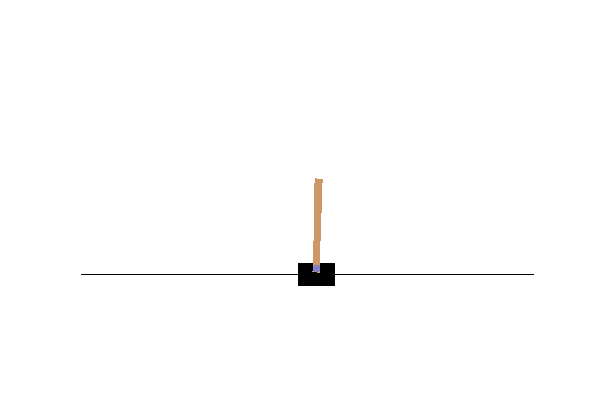
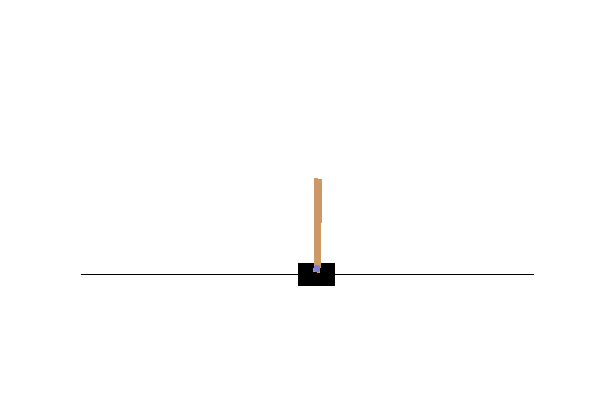
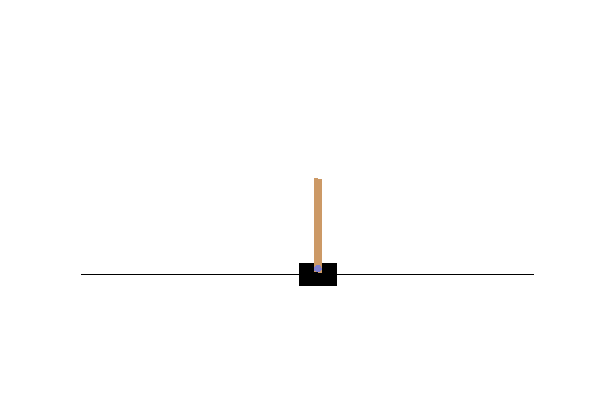
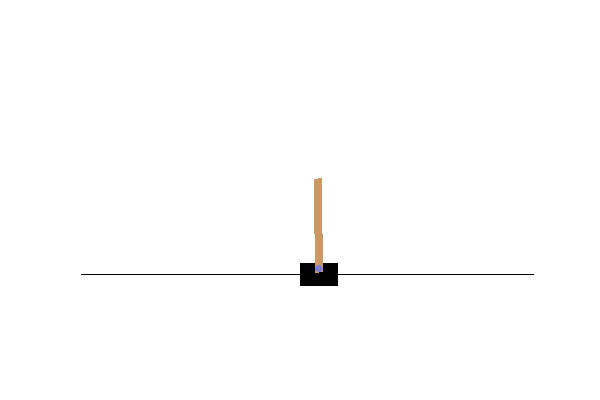
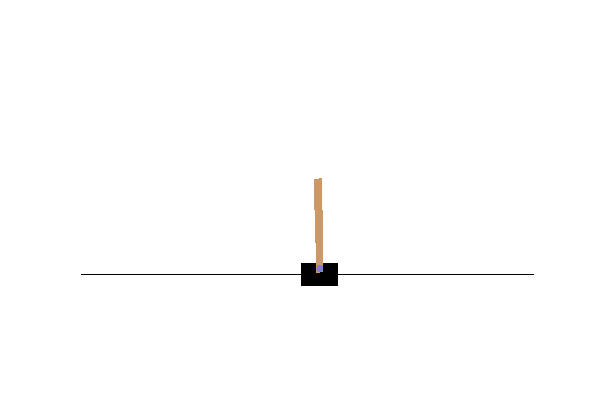
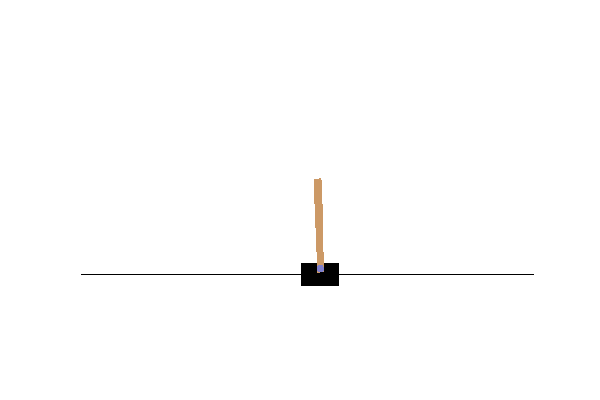
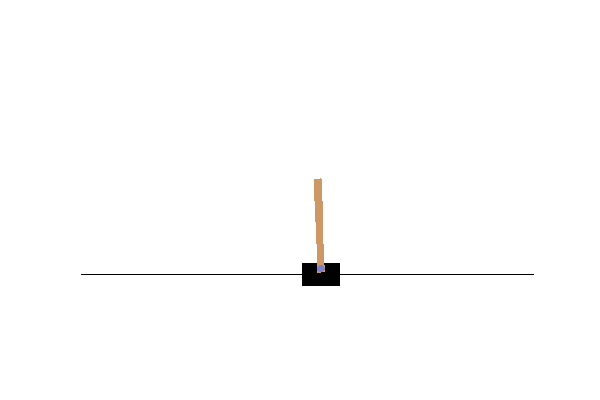
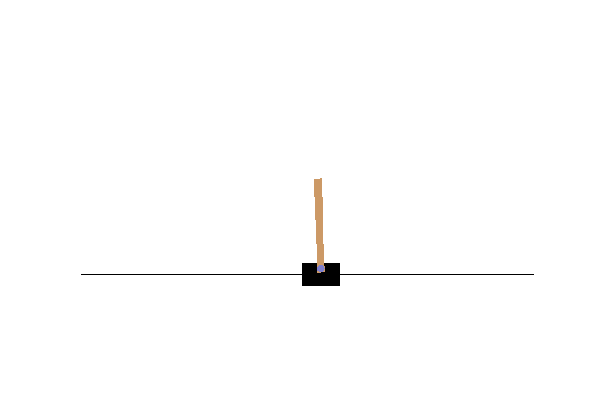
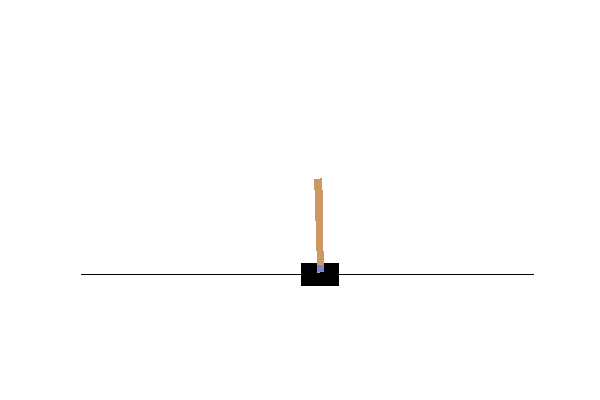
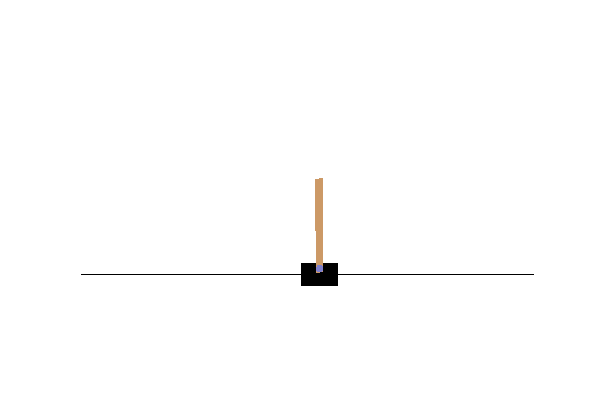
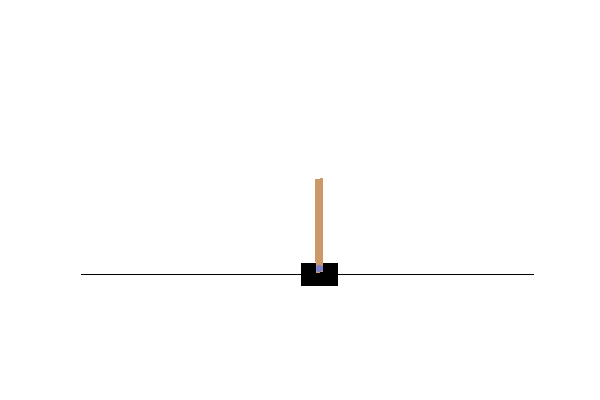
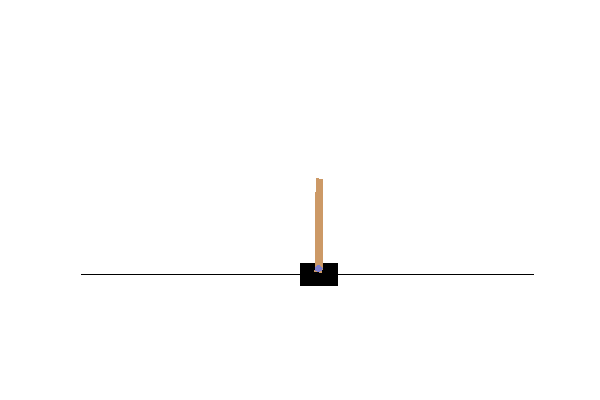
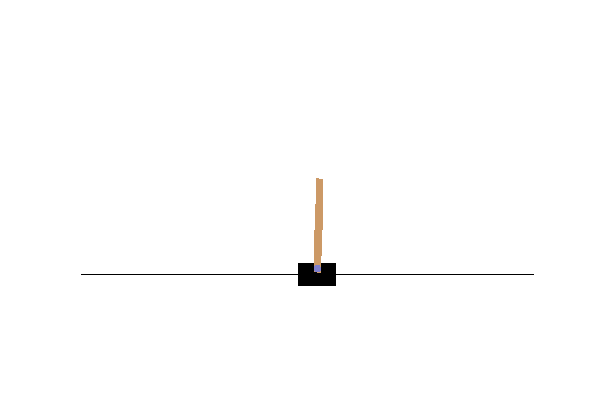
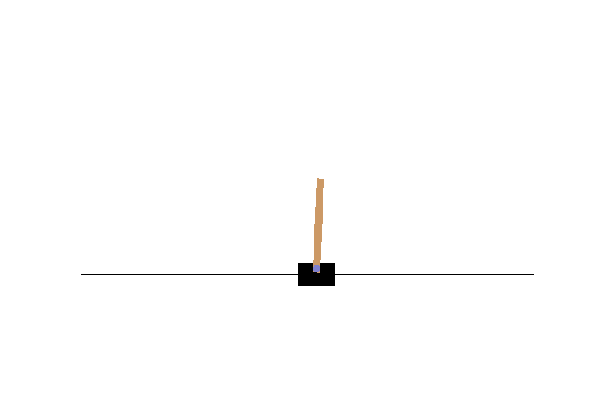
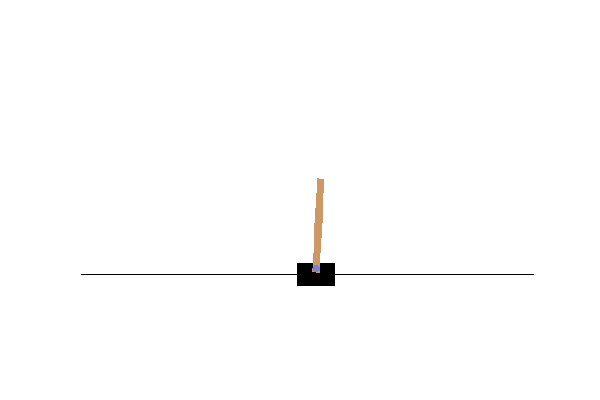
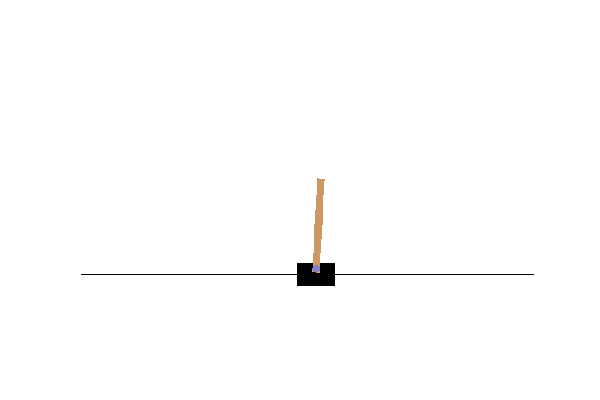
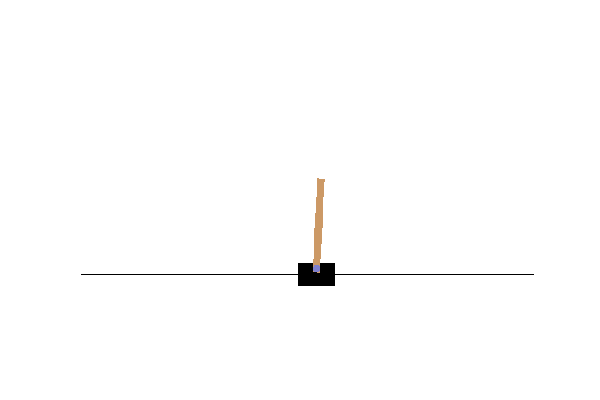
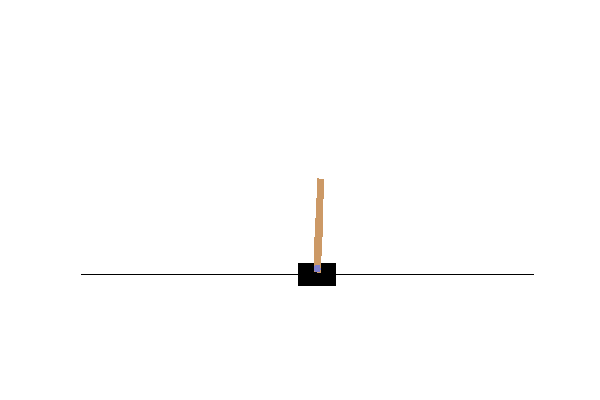
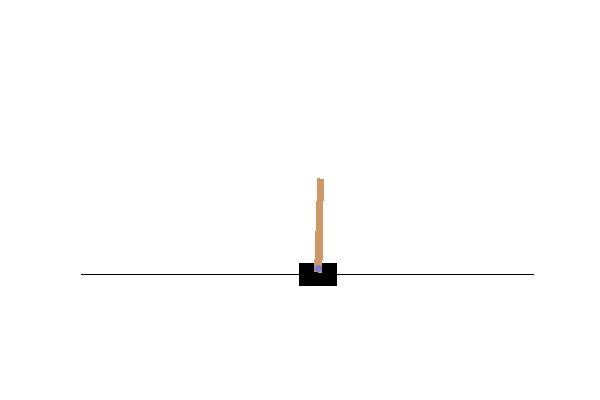
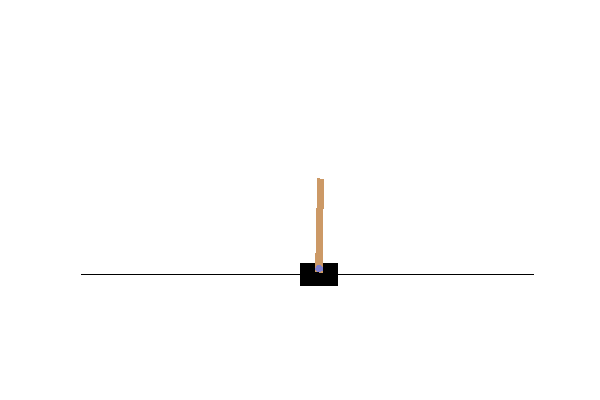
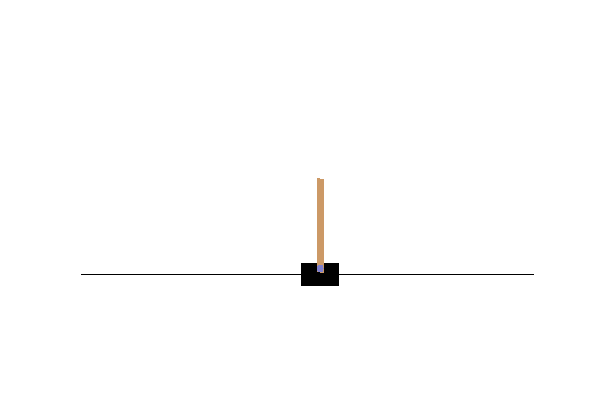
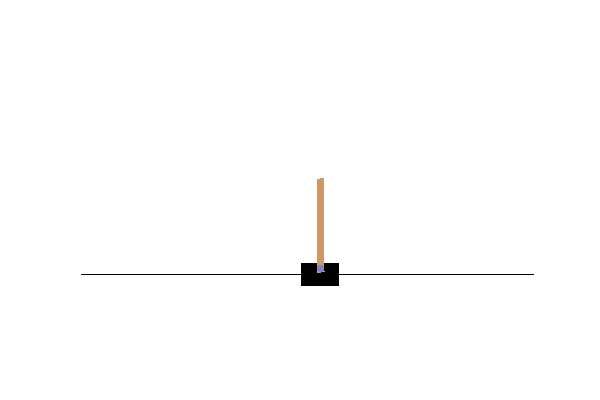
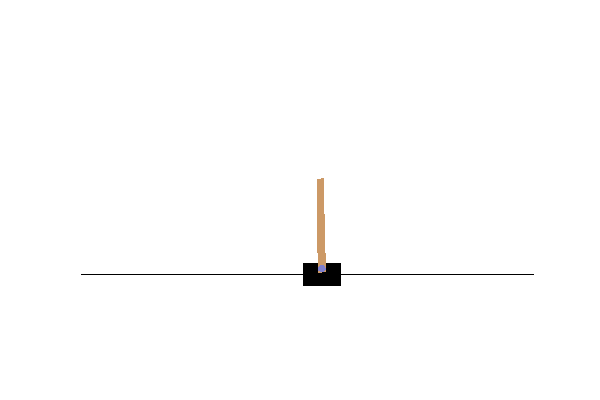
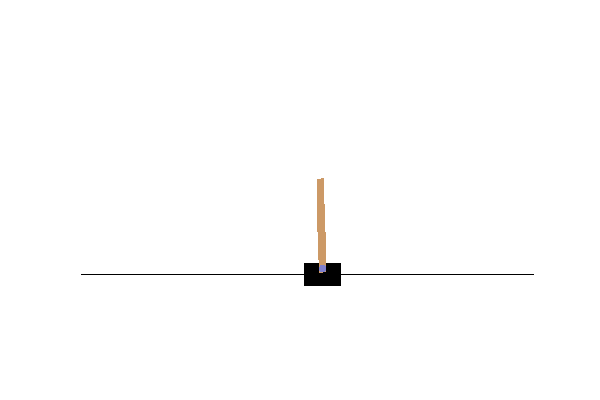
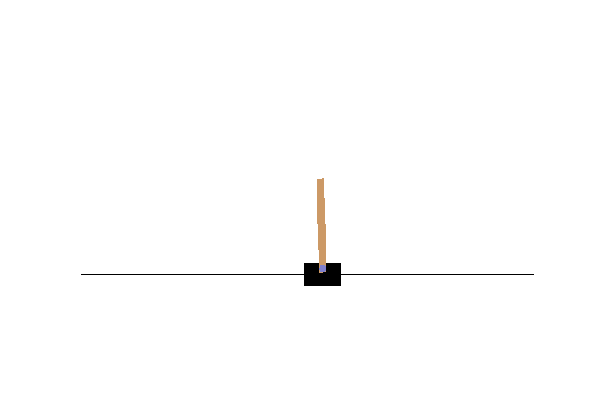
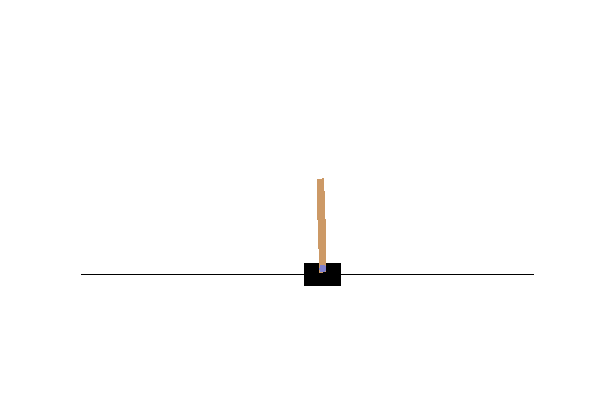
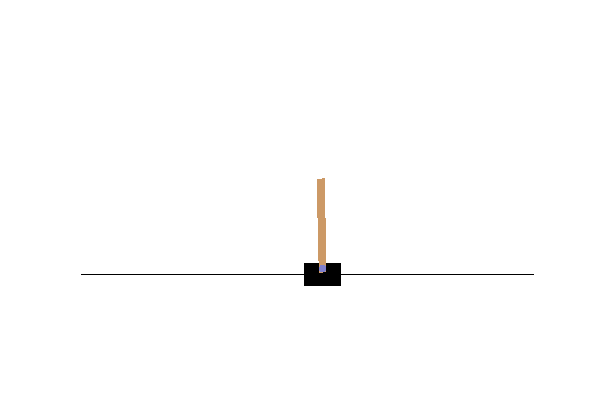
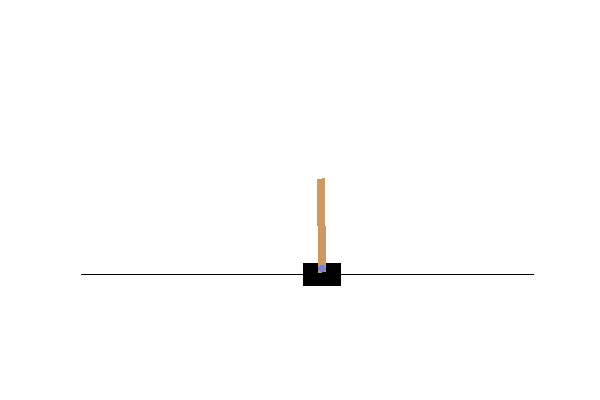
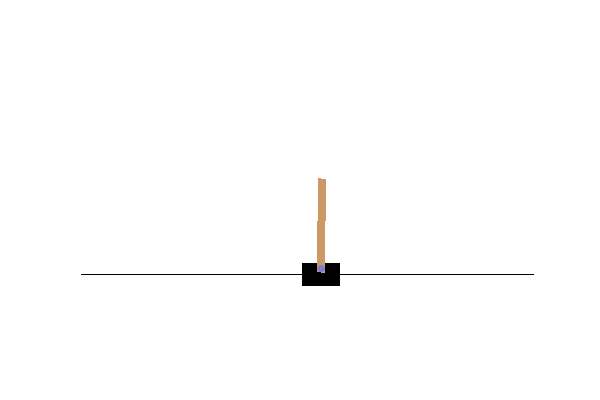
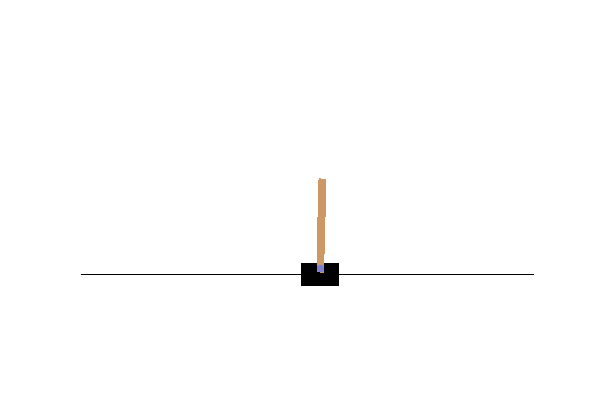
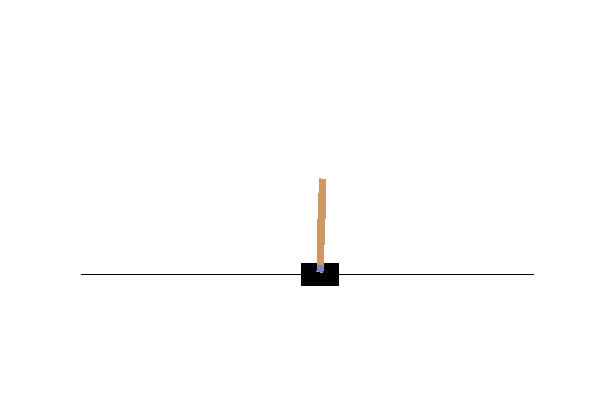
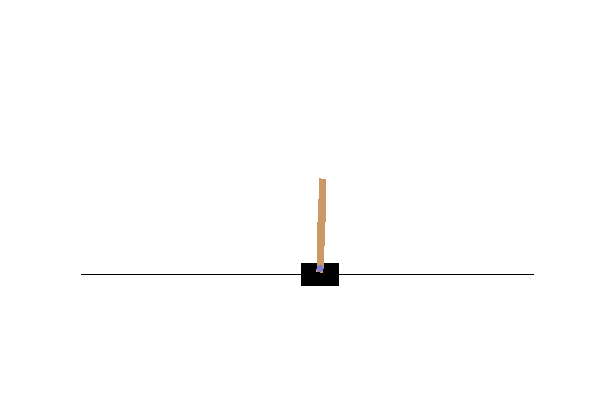
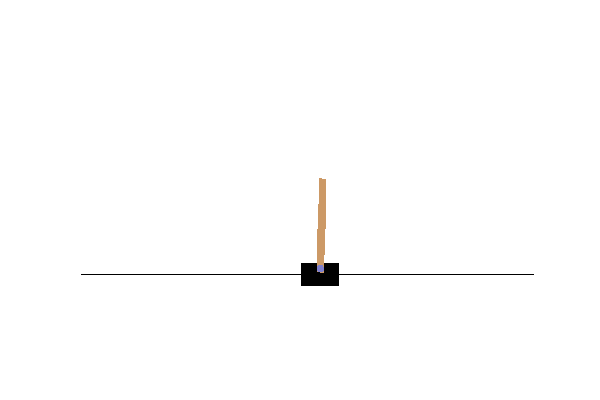
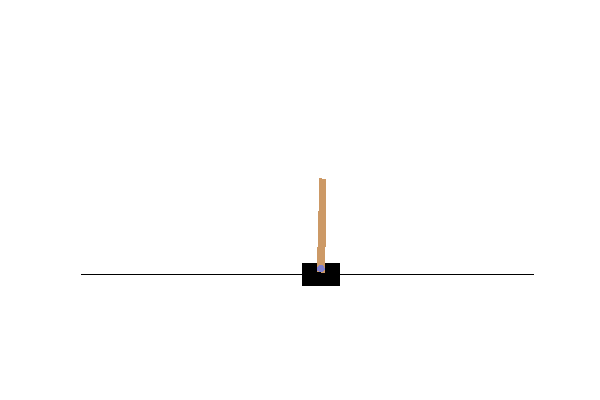
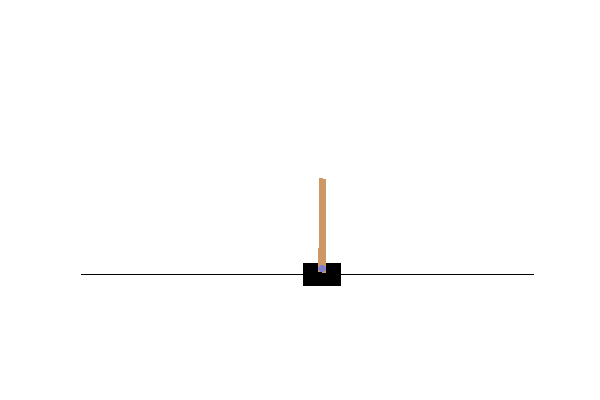
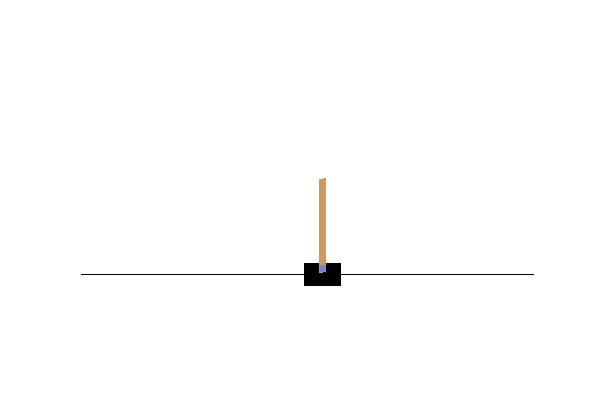
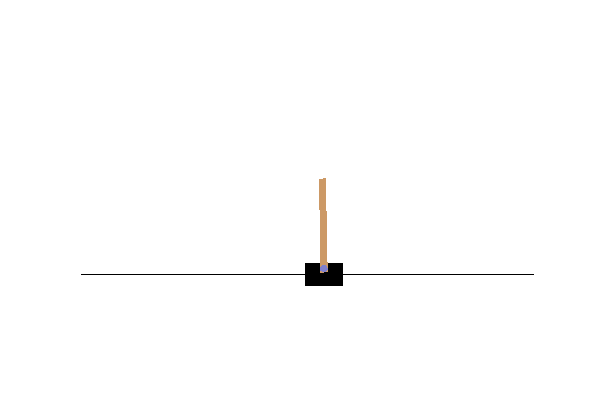
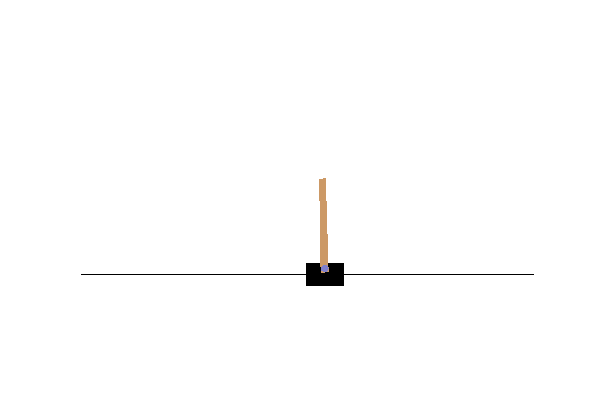
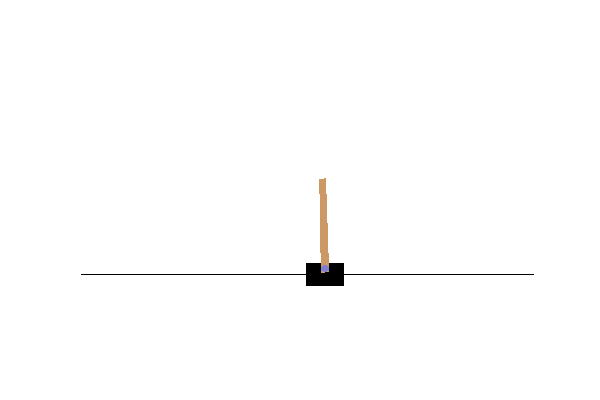
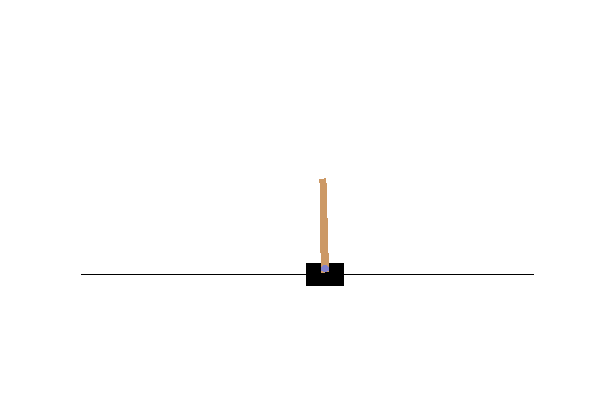
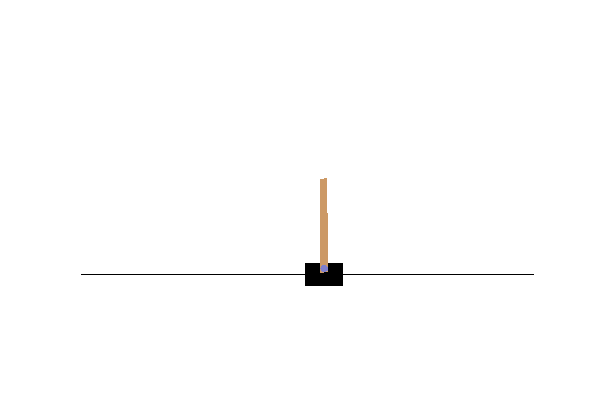
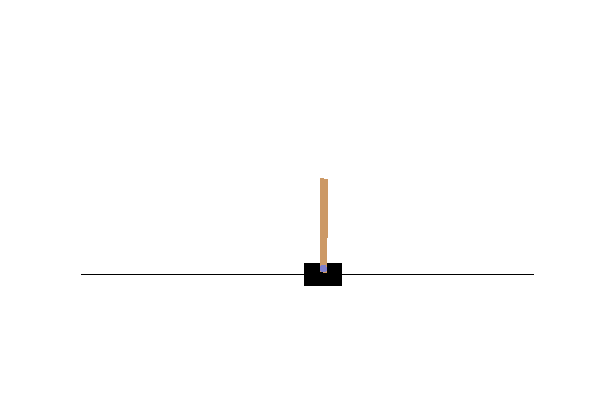
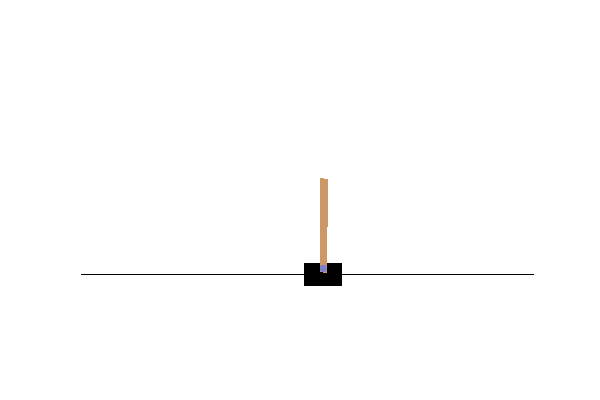
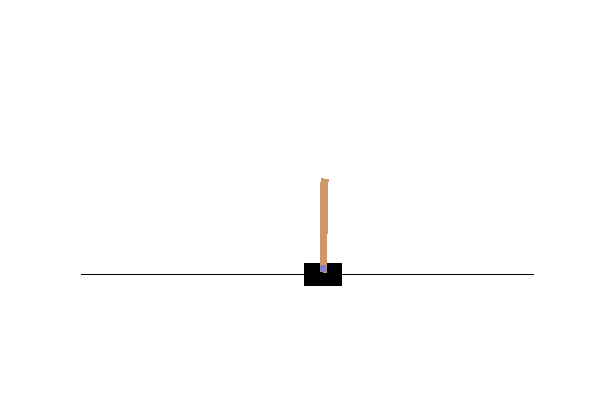
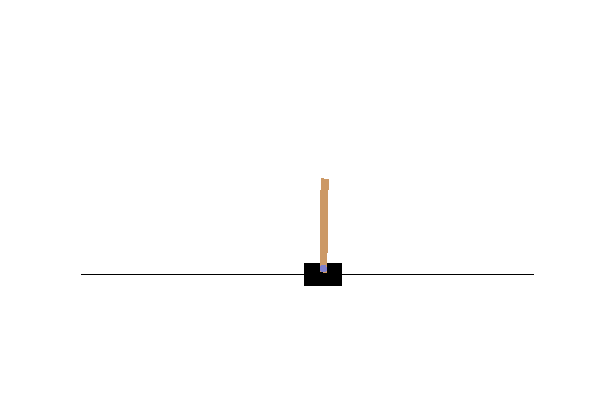
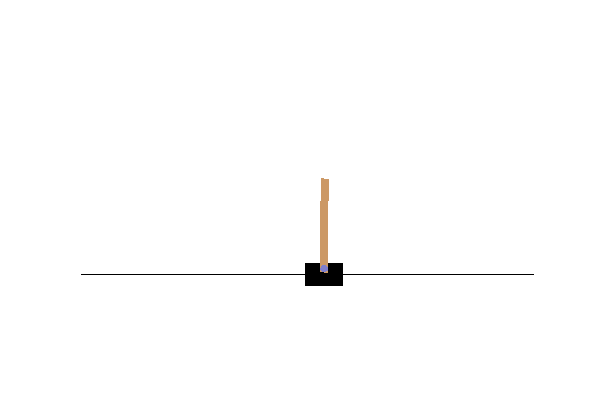
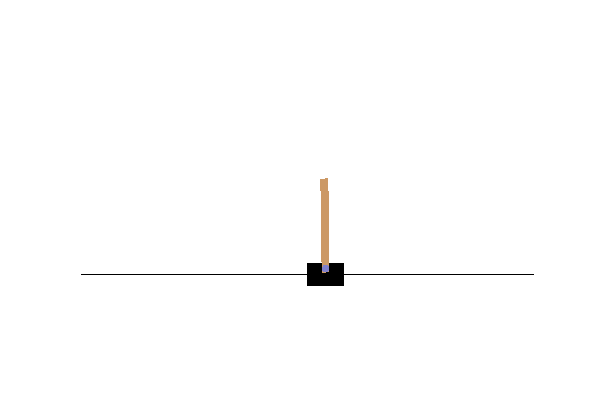
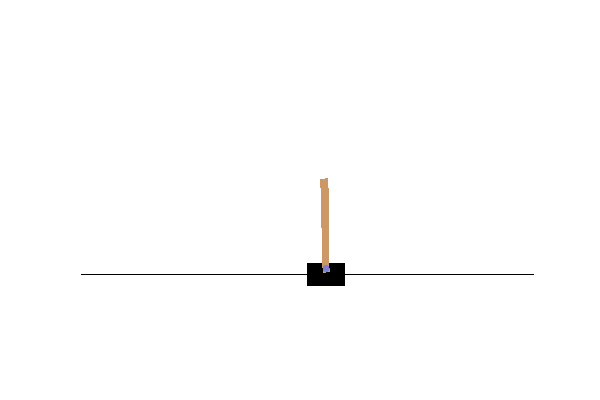
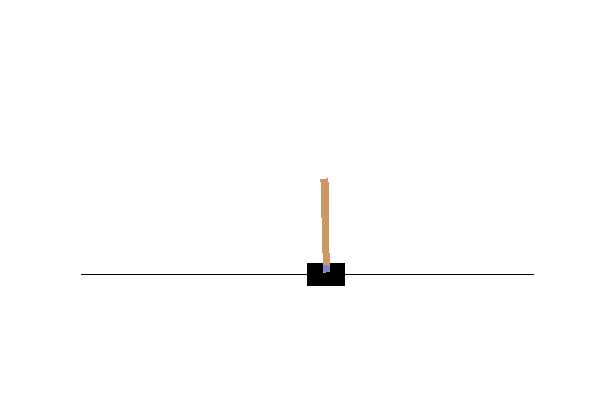
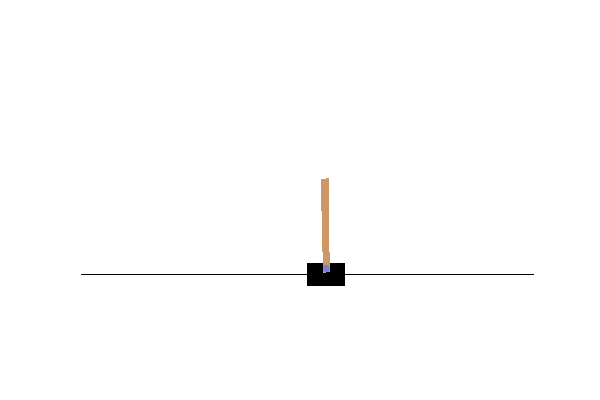
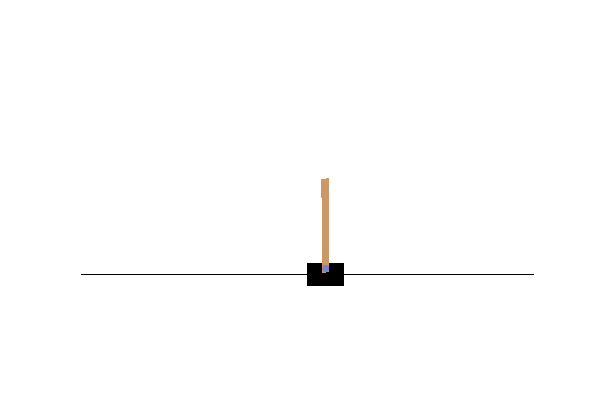
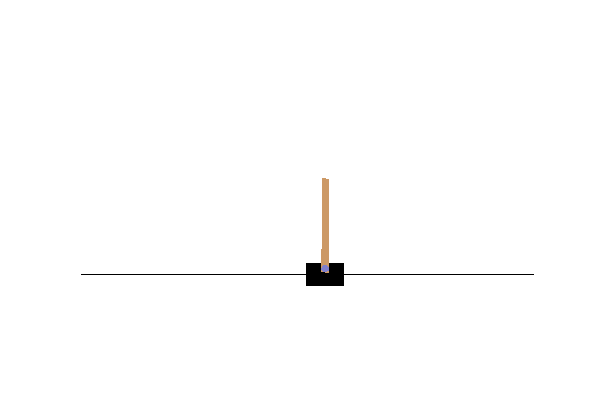
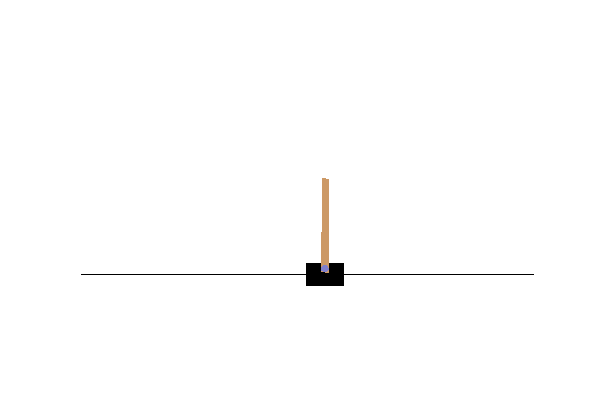
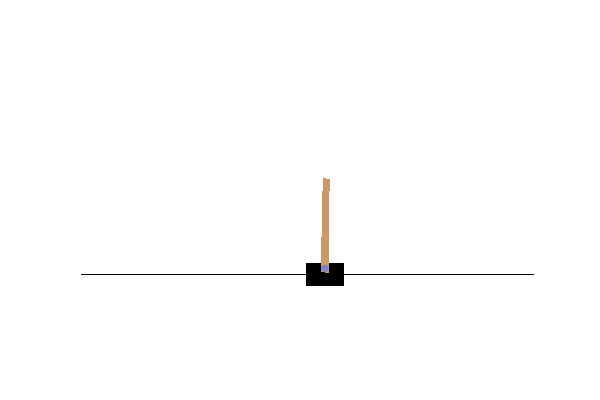
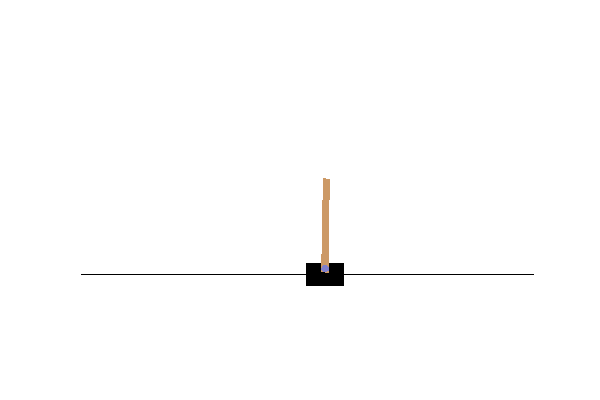
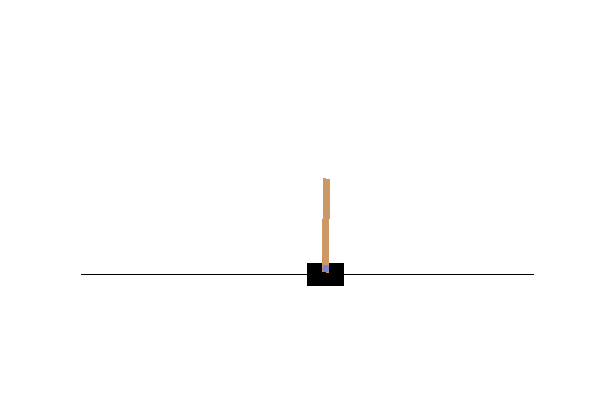
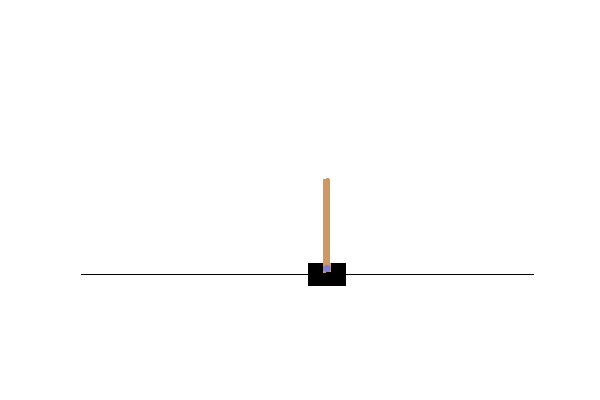
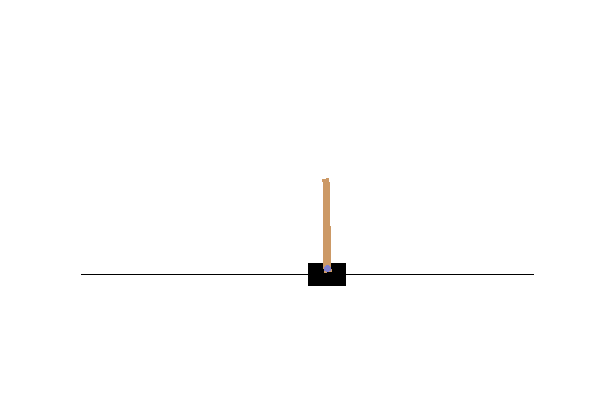
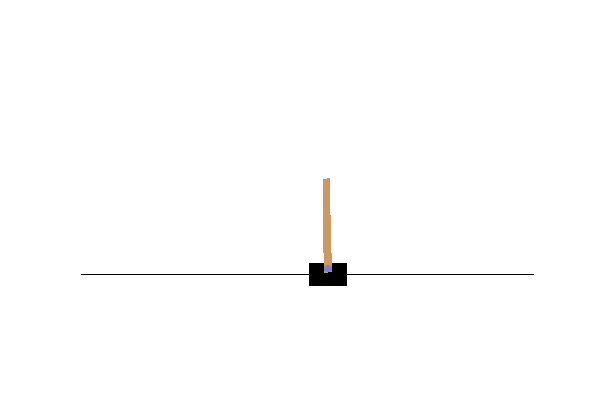
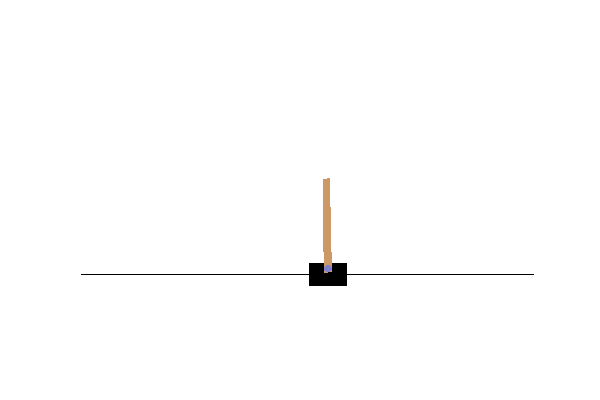
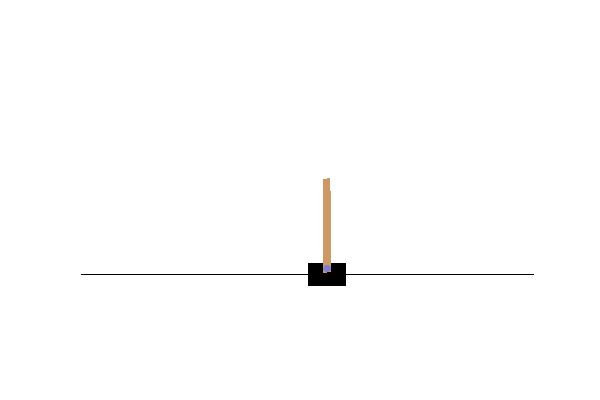
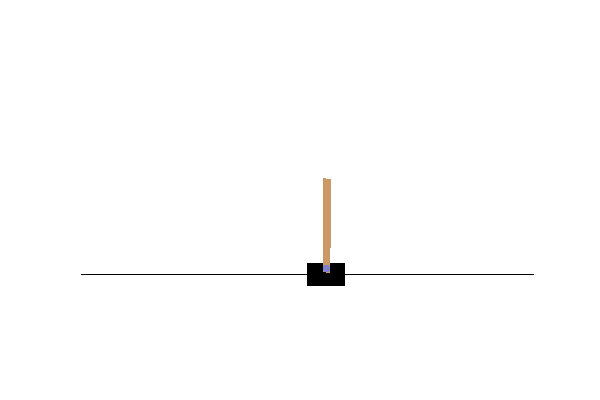
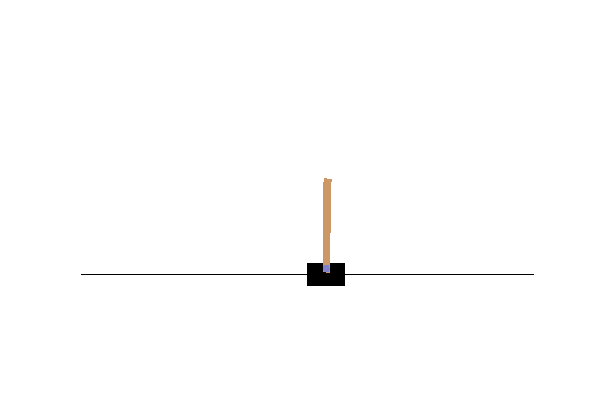
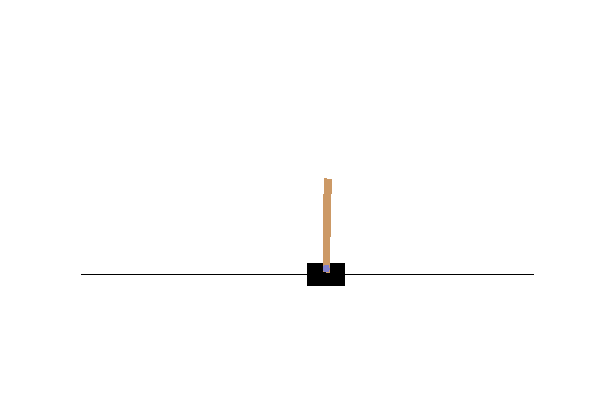
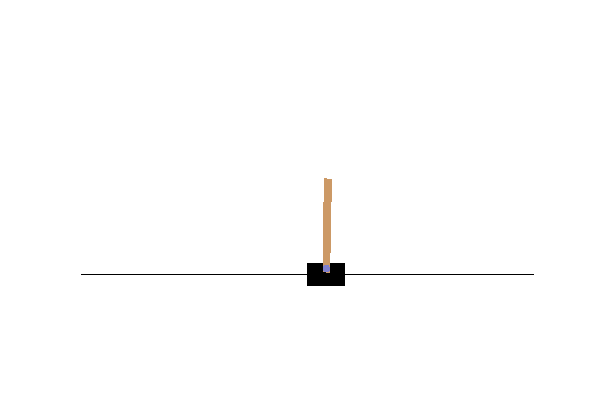
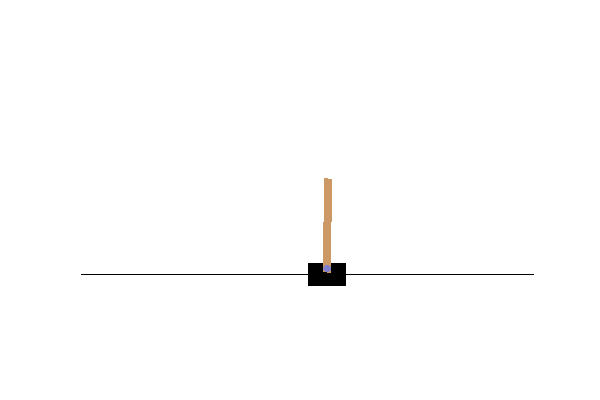
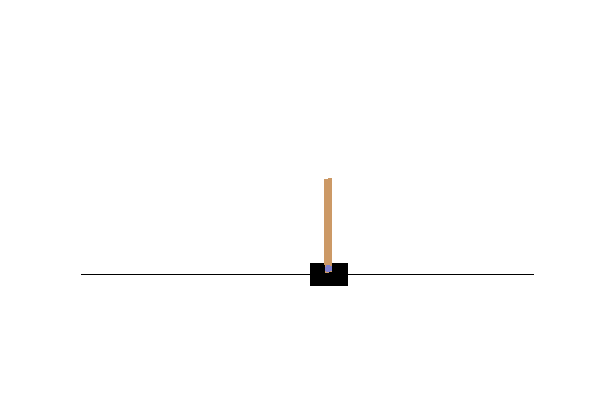
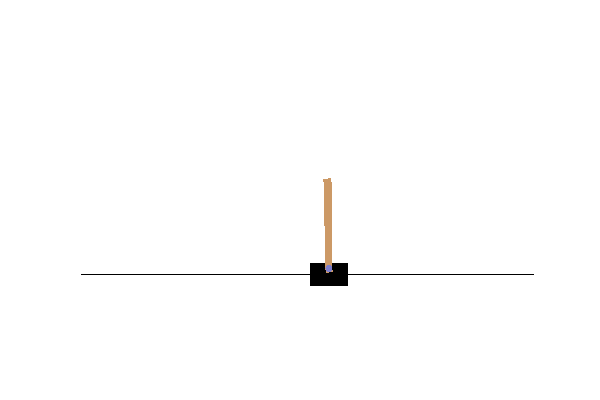
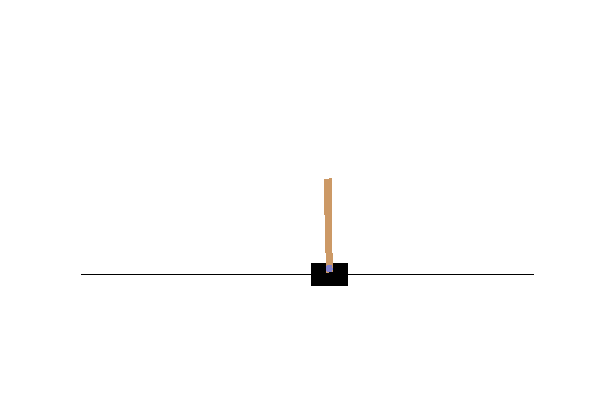
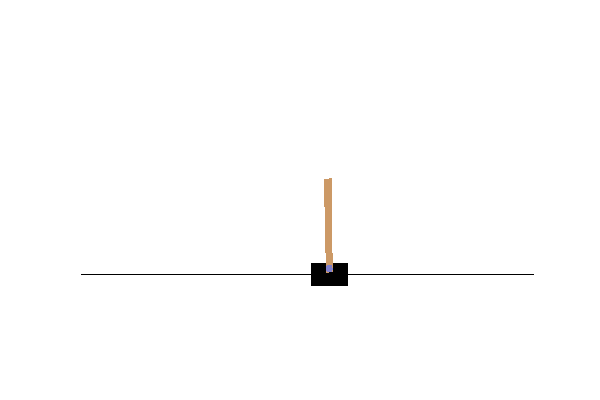
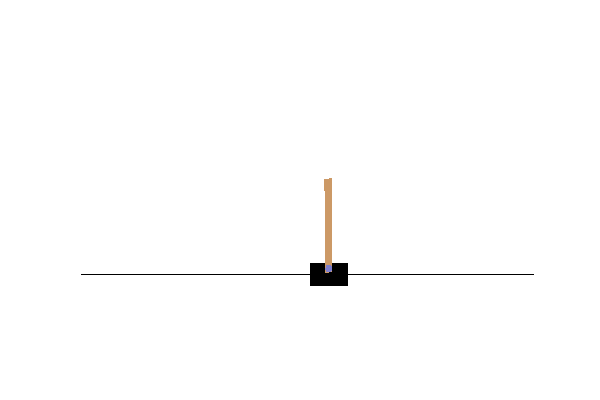
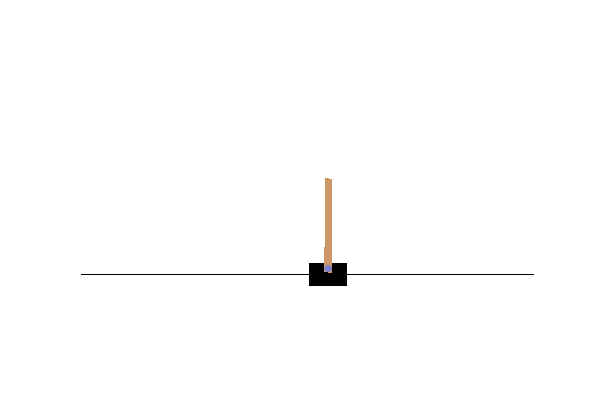
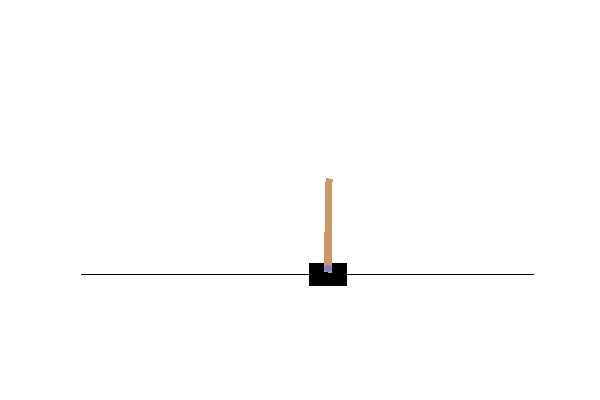
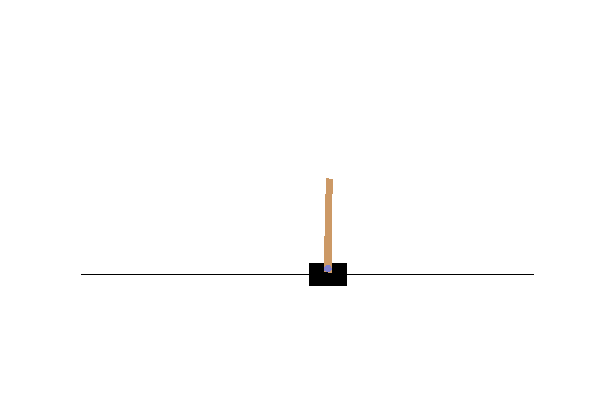
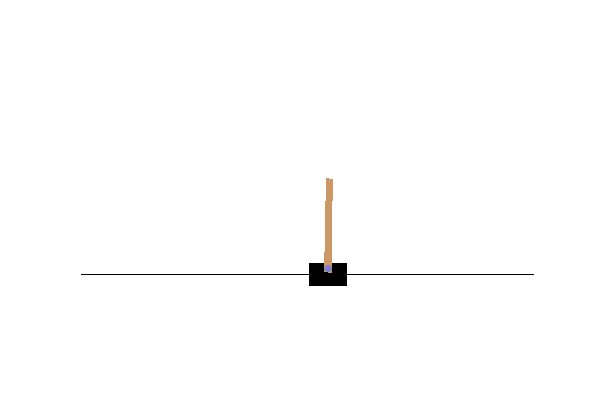
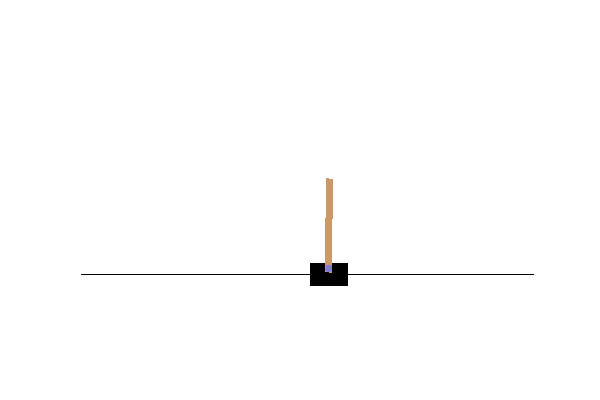
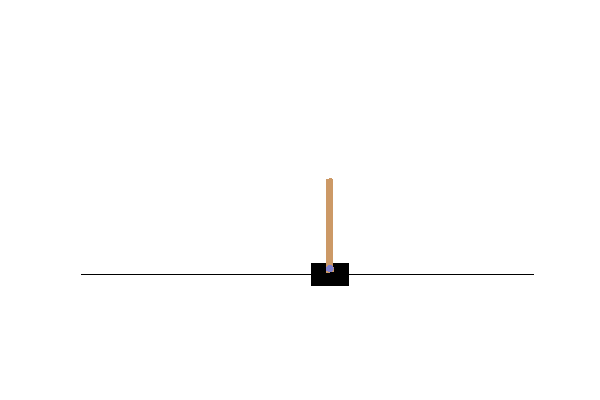
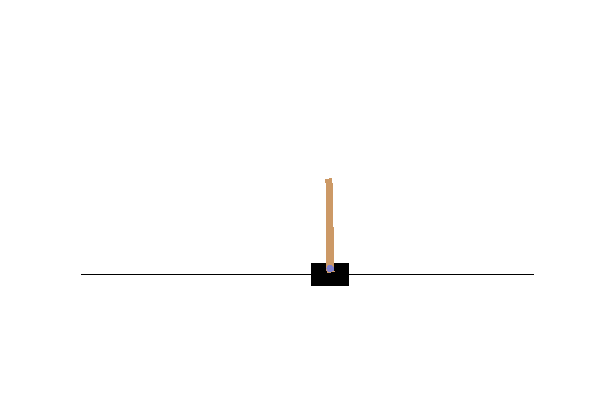
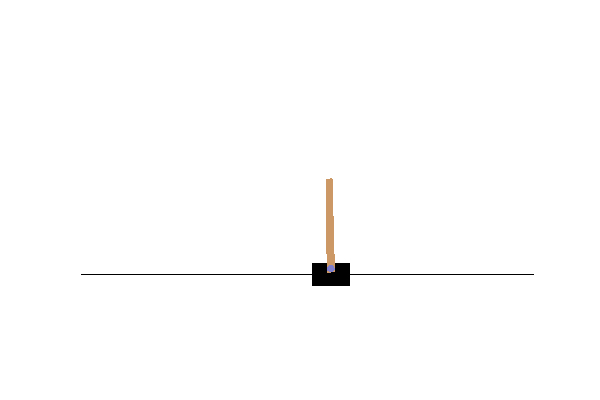
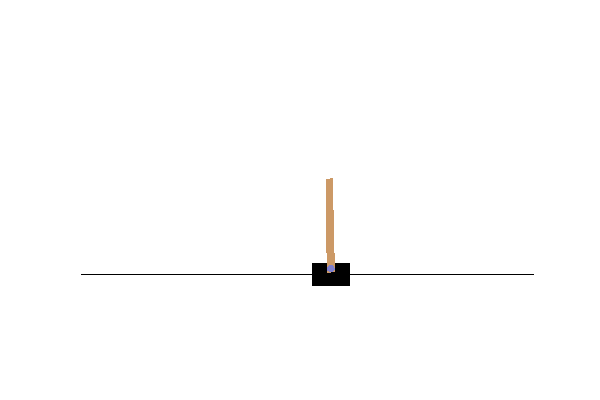
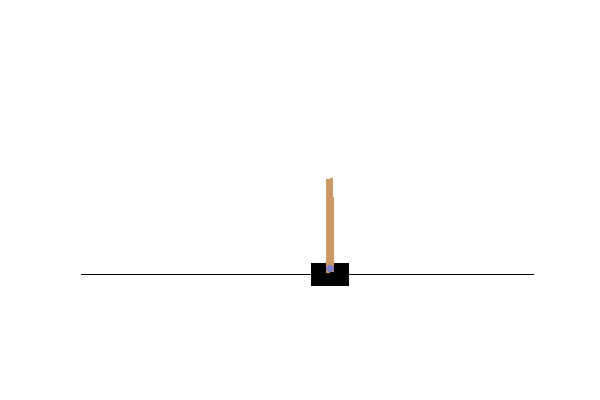
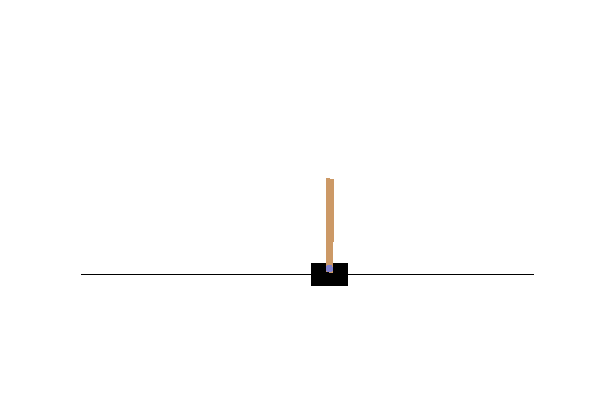
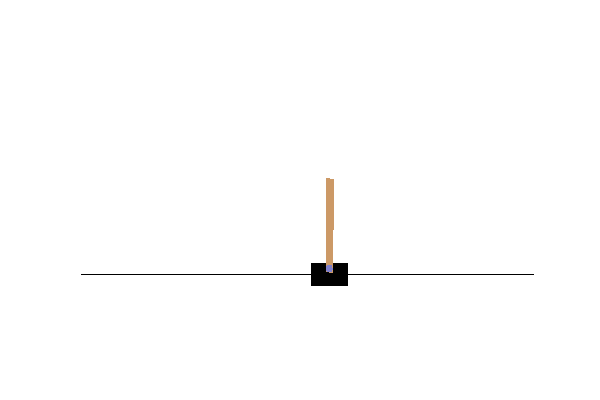
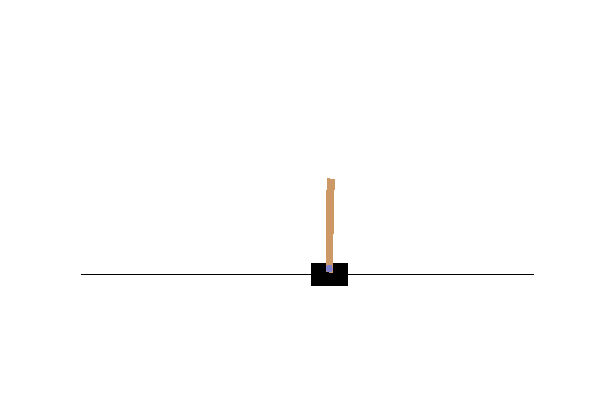
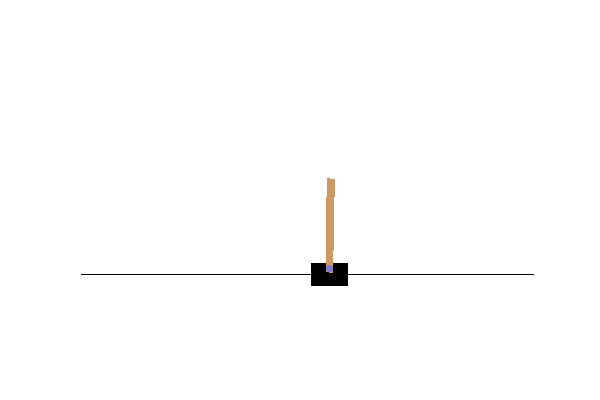
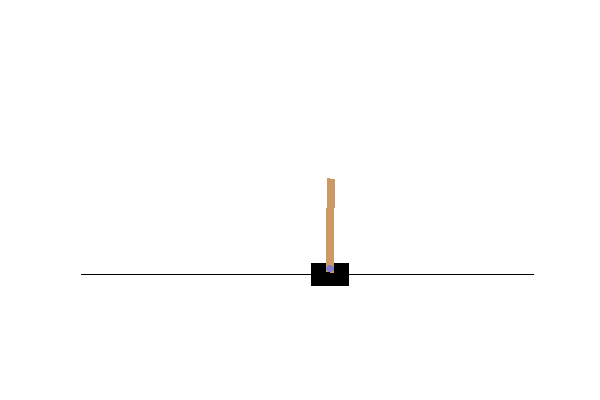
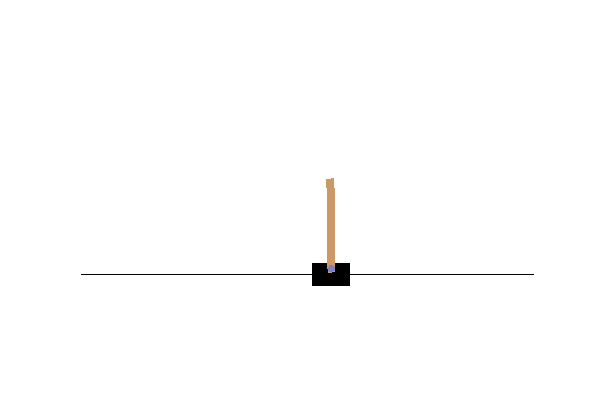
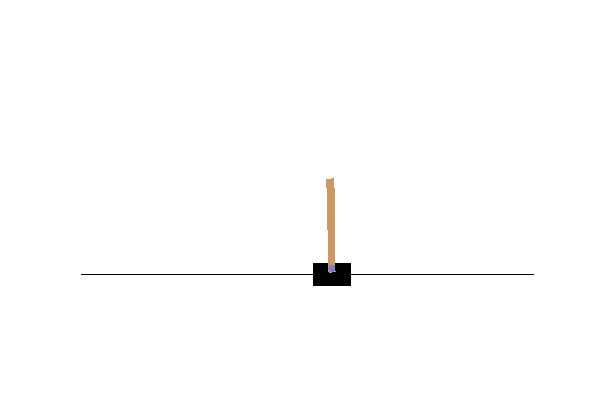
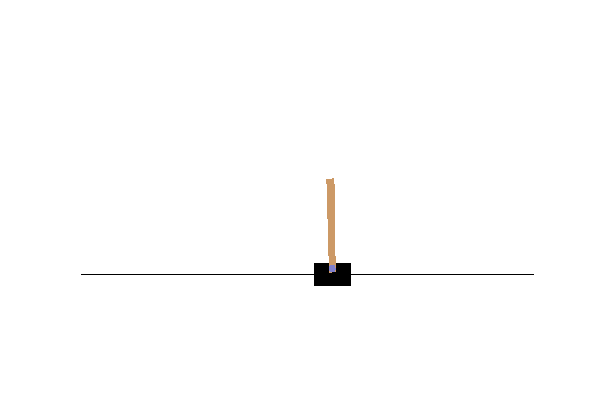
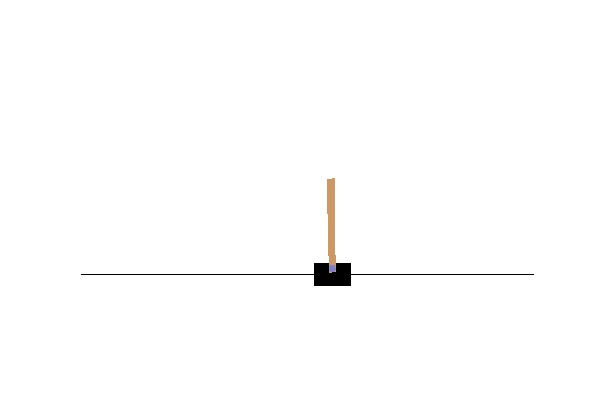
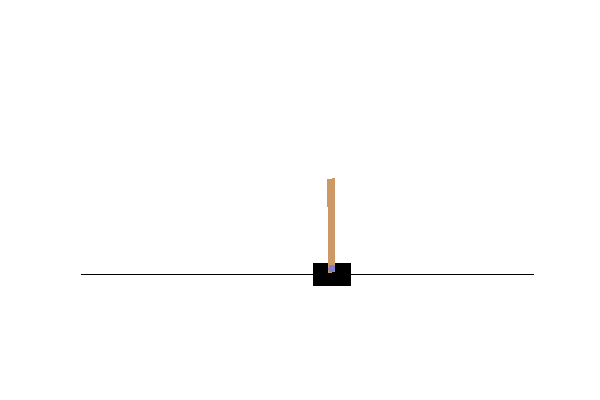
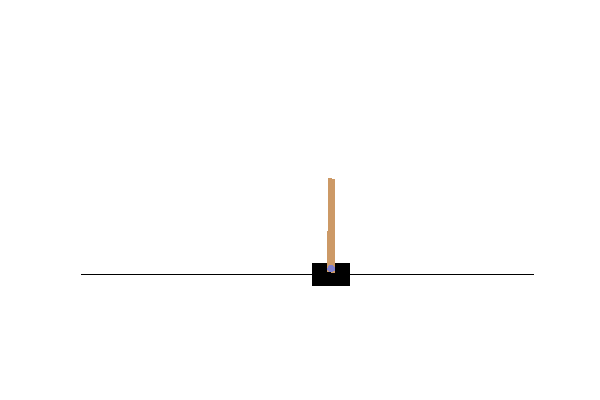
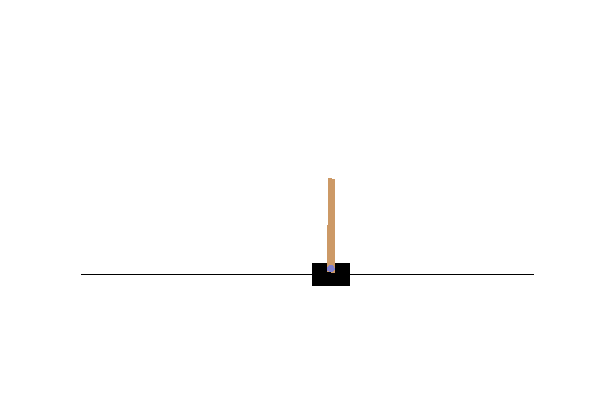
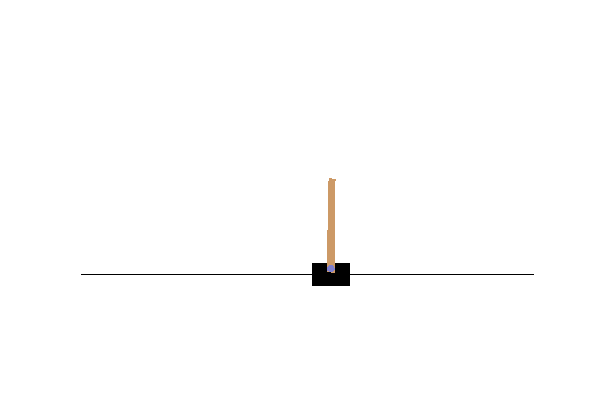

In [9]:
# main
cartpole_env = Environment()
cartpole_env.run()


# classを開いて中身を解明

In [10]:
env = gym.make(ENV)  # 実行する課題を設定
num_states = 4#self.env.observation_space.shape[0]  # 課題の状態の数4を取得
num_actions = 2#self.env.action_space.n  # CartPoleの行動（右に左に押す）の2を取得
agent = Agent(num_states, num_actions)  # 環境内で行動するAgentを生成

In [11]:
brain = Brain(num_states, num_actions) 

In [39]:
observation = env.reset()
print(observation)
brain.digitize_state(observation)

[-0.00529453 -0.02972782  0.02396671  0.02978136]


770

In [47]:
print("Q-tableは{}-dim。縦方向は離散化したstateの数に対応している".format(brain.q_table.shape))

Q-tableは(1296, 2)-dim。縦方向は離散化したstateの数に対応している


## 現在観測されている状態(observation)と何episode目か（$\epsilon$を決めるのに用いる）を与えるとactionが決定される

- Q学習では（Sarsaでもそうだが）確率$\epsilon$でランダムな推移を行う

In [56]:
action = brain.decide_action(observation , episode=1)
_

(array([-0.00258823,  0.35980518,  0.01945745, -0.54007998]), 1.0, False, {})

### breakdown

In [77]:
state = brain.digitize_state(observation)
_

99

In [78]:
episode = 1

In [80]:
epsilon = 0.5 * (1 / (episode + 1))

if epsilon <= np.random.uniform(0, 1):
    action = np.argmax(brain.q_table[state][:])
else:

    action = np.random.choice(num_actions)  # 0,1の行動をランダムに返す
_

99

## actionからnext stateへ

- OpenAI Gymが用意しているメソッド"action"でアップデートできる 

In [113]:
observation_next , reward , done , info = env.step(action)
print(observation_next,  reward , done , info)

[ 0.26407664  0.77032707 -0.40481792 -1.69843096] 0.0 True {}


- actionはrewardも返すがここでは使っていない。
- 使わないことを示すためにアンダースコアで受けるのがpython（のひとつの？）流儀らしい・・

## update q table

In [114]:
brain.update_Q_table(observation = observation, 
                     action = action, 
                     reward = 0, 
                     observation_next =  observation_next)
brain.q_table

array([[0.31705462, 0.00850576],
       [0.77880633, 0.70350831],
       [0.94745893, 0.44942581],
       ...,
       [0.01316661, 0.47581715],
       [0.01165812, 0.71683017],
       [0.61416027, 0.36229611]])

### breakdown

#### step前の状態を離散化

In [97]:
state = brain.digitize_state(observation)  # 状態を離散化
state

770

#### step後の状態も離散化

In [98]:
state_next = brain.digitize_state(observation_next)  # 次の状態を離散化

#### step後の状態に対応する行でのQの最大値を求める

In [ ]:
Max_Q_next = max(brain.q_table[state_next][:])

In [101]:
Max_Q_next

0.9152388007926829

#### step前の状態において選択されたアクションを取った場合のQの値を「将来価値のDCFバリューに近づける」方式でアップデート

In [105]:
brain.q_table[state, action] = brain.q_table[state, action] +  ETA * (reward + GAMMA * Max_Q_next - brain.q_table[state, action])

In [116]:
%%bash
git commit -a -m "doing 3_4"

[master 75f7eac] doing 3_4
 1 file changed, 74 insertions(+), 20 deletions(-)
